---

**設定：Setting**


In [2]:
# 建物レベル最適運転計画（簡潔版）
# - 入力: ac_control_processed_Clea.csv, power_meter_processed_Clea.csv
# - 出力: 予測モデル（MultiOutput）で室内温度/電力を予測し、天気予報に基づき簡易に最適計画を算出
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 建物レベル横持ち特徴量の作成 + 単一モデル(XGBoost)学習（多出力）
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Safe JP font setup without warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
import warnings

# 使える候補（環境にあるものを自動選択）
preferred = [
    "Hiragino Sans",  # macOS
    "Hiragino Kaku Gothic ProN",
    "Yu Gothic",  # Windows
    "MS Gothic",
    "AppleGothic",  # macOS 代替
    "Arial Unicode MS",  # 広範囲
    "DejaVu Sans",  # 最終手段（英数・一部日本語）
]

# システムフォント一覧から存在チェック
available = set(font_manager.get_font_names())
font_name = next((f for f in preferred if f in available), "DejaVu Sans")

# 参照しない（存在しないフォント名をrcParamsから除外）
mpl.rcParams["font.family"] = font_name
mpl.rcParams["font.sans-serif"] = [font_name]
mpl.rcParams["axes.unicode_minus"] = False

# 旧セルで指定した未インストール名をクリア（必要なら）
for k in ["font.family", "font.sans-serif"]:
    mpl.rcParams[k] = [font_name]

# findfont の警告を抑制
mpl.set_loglevel("error")
warnings.filterwarnings("ignore", message=r"findfont: Font family '.*' not found")

print(f"Using font: {font_name}")


# プロジェクトルート
cwd = Path.cwd()
project_root = cwd.parent if cwd.name == "notebooks" else cwd
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("Project root:", project_root)

Using font: Hiragino Sans
Project root: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic


In [3]:
# パス設定（必要に応じて変更）
DATA_DIR = project_root / "data/02_PreprocessedData/Clea"
AC_CONTROL_CSV = DATA_DIR / "ac_control_processed_Clea.csv"
WEATHER_CSV = DATA_DIR / "weather_processed_Clea.csv"
POWER_METER_CSV = DATA_DIR / "power_meter_processed_Clea.csv"

# 天気予報（本来はAPI取得、ここでは簡潔のため既存の予報CSVを指定可能）
FORECAST_CSV = (
    project_root / "data/04_PlanningData/Clea/weather_forecast_20250929_20251004.csv"
)

print("AC control:", AC_CONTROL_CSV)
print("Power:", POWER_METER_CSV)
print("Forecast:", FORECAST_CSV)

AC control: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic/data/02_PreprocessedData/Clea/ac_control_processed_Clea.csv
Power: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic/data/02_PreprocessedData/Clea/power_meter_processed_Clea.csv
Forecast: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic/data/04_PlanningData/Clea/weather_forecast_20250929_20251004.csv


---

**前処理：pre-Processing**


In [4]:
# 計測ユーティリティ
import time, cProfile, pstats, io


def section_time(label, func, *args, **kwargs):
    t0 = time.perf_counter()
    out = func(*args, **kwargs)
    dt = time.perf_counter() - t0
    print(f"[TIME] {label}: {dt:.2f}s")
    return out


def profile_block(run_callable, sort_by="cumtime", lines=30):
    pr = cProfile.Profile()
    pr.enable()
    run_callable()
    pr.disable()
    s = io.StringIO()
    pstats.Stats(pr, stream=s).sort_stats(sort_by).print_stats(lines)
    print(s.getvalue())

In [6]:
# データ読み込みと前処理（簡潔版）
assert AC_CONTROL_CSV.exists(), f"not found: {AC_CONTROL_CSV}"
assert POWER_METER_CSV.exists(), f"not found: {POWER_METER_CSV}"

ac = pd.read_csv(AC_CONTROL_CSV)
pw = pd.read_csv(POWER_METER_CSV)

# 列名BOM除去と datetime 統一
ac.columns = ac.columns.str.replace("\ufeff", "")
pw.columns = pw.columns.str.replace("\ufeff", "")

datetime_col = "Datetime" if "Datetime" in ac.columns else "datetime"
ac[datetime_col] = pd.to_datetime(ac[datetime_col])
pw[datetime_col] = pd.to_datetime(pw[datetime_col])

# 時刻列を統一
ac["Datetime"] = ac["Datetime"] if "Datetime" in ac.columns else ac["datetime"]
ac["Datetime"] = pd.to_datetime(ac["Datetime"])

# 室内機の識別（unit_id or indoor_id 的な列名推定）
UNIT_ID = "A/C Name"
# 固定順のユニット一覧
units_fixed = sorted(ac[UNIT_ID].dropna().unique().tolist())
units_fixed

['A-25',
 'A-26',
 'D-1南1',
 'D-2北1',
 'D-3南2',
 'D-4北2',
 'D-5南1',
 'D-6北1',
 'D-7南2',
 'D-8北2',
 'E-10南2',
 'E-11南3',
 'E-12南4',
 'E-13北1',
 'E-14北2',
 'E-15北3',
 'E-16北4',
 'E-17',
 'E-9南1',
 'F-18',
 'F-19',
 'F-20',
 'G-21',
 'G-22',
 'G-23',
 'G-24']

In [7]:
# 必要そうな列の推定
col_map = {
    "set_temp": None,
    "mode": None,
    "fan": None,
    "onoff": None,
    "indoor_temp": None,
    "outdoor_temp": None,
    "solar": None,
}
for c in ac.columns:
    cl = c.lower()
    if col_map["set_temp"] is None and ("set" in cl and "temp" in cl):
        col_map["set_temp"] = c
    if col_map["mode"] is None and "mode" in cl:
        col_map["mode"] = c
    if col_map["fan"] is None and "fan" in cl:
        col_map["fan"] = c
    if col_map["onoff"] is None and (
        "on/off" in cl or "on_off" in cl or "onoff" in cl or "a/c on/off" in cl
    ):
        col_map["onoff"] = c
    if col_map["indoor_temp"] is None and ("indoor" in cl and "temp" in cl):
        col_map["indoor_temp"] = c
    if col_map["outdoor_temp"] is None and ("outdoor" in cl and "temp" in cl):
        col_map["outdoor_temp"] = c
    if col_map["solar"] is None and ("solar" in cl):
        col_map["solar"] = c

In [3]:
from datetime import datetime

import pandas as pd
from prettytable import PrettyTable


class DataManager:
    @classmethod
    def show_status(self, df: pd.DataFrame):
        table = PrettyTable(
            ["Variable", "Type", "Missing Values", "Duplicates", "Outliers"]
        )

        for col in df.columns:
            # データ型の判定
            if pd.api.types.is_numeric_dtype(df[col]):
                col_type = "Numerical"
            else:
                col_type = "Categorical"

            # 欠損値
            missing_values = df[col].isnull().sum()

            # 重複数
            duplicates = df.duplicated(subset=[col]).sum()

            # 外れ値（数値型のみ）
            if col_type == "Numerical":
                mean = df[col].mean()
                std = df[col].std()
                outliers = ((df[col] - mean).abs() > 3 * std).sum()
            else:
                outliers = "N/A"

            table.add_row([col, col_type, missing_values, duplicates, outliers])
        print(table)

    @classmethod
    def extract_term_data(
        cls, target_col: str, df: pd.DataFrame, start_time: datetime, end_time: datetime
    ):
        df[target_col] = pd.to_datetime(df[target_col])
        filtered_df = df[(df[target_col] >= start_time) & (df[target_col] <= end_time)]
        return filtered_df

    @classmethod
    def check_date_sequence(cls, df: pd.DataFrame, date_col: str = "date"):
        dates = pd.to_datetime(df[date_col]).sort_values().reset_index(drop=True)
        expected = pd.date_range(start=dates.min(), end=dates.max(), freq="D")
        missing = expected.difference(dates)
        return {
            "is_continuous": len(missing) == 0,
            "missing_dates": missing.strftime("%Y-%m-%d").tolist(),
        }

In [9]:
DataManager.show_status(ac)
print(len(ac))

+---------------------+-------------+----------------+------------+----------+
|       Variable      |     Type    | Missing Values | Duplicates | Outliers |
+---------------------+-------------+----------------+------------+----------+
|       Datetime      | Categorical |       0        |  3205254   |   N/A    |
|         Date        | Categorical |       0        |  3335400   |   N/A    |
|       A/C Name      | Categorical |       0        |  3335830   |   N/A    |
|    Outdoor Temp.    |  Numerical  |       0        |  3335811   |    0     |
|     Indoor Temp.    |  Numerical  |       0        |  3335810   |  13070   |
| A/C Set Temperature |  Numerical  |       0        |  3335838   |  13510   |
|      A/C ON/OFF     | Categorical |       0        |  3335854   |   N/A    |
|       A/C Mode      | Categorical |     44361      |  3335852   |   N/A    |
|    A/C Fan Speed    | Categorical |    2352277     |  3335850   |   N/A    |
|  Naive Energy Level |  Numerical  |       0       

ここで、カテゴリカルを numerical へ変換する処理を加える


In [10]:
activate_replace_dict = {"OFF": 0, "ON": 1}
mode_replace_dict = {"FAN": 0, "COOL": 1, "HEAT": 2}
fan_replace_dict = {"Low": 0, "Medium": 1, "High": 2, "Top": 3, "Auto": 4}
ac["A/C ON/OFF"] = (
    ac["A/C ON/OFF"].astype(str).str.strip().str.upper().map(activate_replace_dict)
)
ac["A/C Mode"] = (
    ac["A/C Mode"].astype(str).str.strip().str.upper().map(mode_replace_dict)
)
ac["A/C Fan Speed"] = (
    ac["A/C Fan Speed"].astype(str).str.strip().str.title().map(fan_replace_dict)
)

In [11]:
DataManager.show_status(pw)
print(len(pw))

+------------+-------------+----------------+------------+----------+
|  Variable  |     Type    | Missing Values | Duplicates | Outliers |
+------------+-------------+----------------+------------+----------+
|  Datetime  | Categorical |       0        |  1869023   |   N/A    |
|    Date    | Categorical |       0        |  2517503   |   N/A    |
|  Mesh ID   |  Numerical  |       0        |  2517955   |    0     |
| PM Addr ID |  Numerical  |       0        |  2517950   |    0     |
|  Phase A   |  Numerical  |       0        |  2515287   |  67473   |
|  Phase B   |  Numerical  |       0        |  2517958   |    0     |
|  Phase C   |  Numerical  |       0        |  2517958   |    0     |
| Total_kWh  |  Numerical  |       0        |  2515287   |  67473   |
+------------+-------------+----------------+------------+----------+
2517959


In [12]:
# 室内機(ac)・室外機(pw)をグルーピングして、時刻別（時刻×ユニット）の横持ちテーブルに変換

import pandas as pd
import numpy as np


# 1) 時刻列を統一＆時単位に丸め
def to_hourly(df, dt_col):
    df = df.copy()
    df[dt_col] = pd.to_datetime(df[dt_col])
    df["Datetime_hour"] = df[dt_col].dt.floor("H")
    return df


# 2) 室内機（A/C Name）× 時刻で集約 → 横持ち
#    - 集約指標の例:
#      set_temp: 平均, mode/fan/onoff: 最頻値, indoor_temp: 平均
def pivot_indoor(
    ac: pd.DataFrame,
    unit_col="A/C Name",
    dt_col="Datetime",
    set_temp_col=None,
    mode_col=None,
    fan_col=None,
    onoff_col=None,
    indoor_temp_col=None,
):
    ac1 = to_hourly(ac, dt_col)

    agg_map = {}
    if set_temp_col:
        agg_map[set_temp_col] = "mean"
    if indoor_temp_col:
        agg_map[indoor_temp_col] = "mean"

    # 最頻値集計（mode/fan/onoff）
    def mode_agg(s):
        s = pd.to_numeric(s, errors="coerce")
        s = s.dropna().astype(int)
        return s.mode().iloc[0] if len(s) else np.nan

    if mode_col:
        agg_map[mode_col] = mode_agg
    if fan_col:
        agg_map[fan_col] = mode_agg
    if onoff_col:
        agg_map[onoff_col] = mode_agg

    g = ac1.groupby(["Datetime_hour", unit_col], as_index=False).agg(agg_map)

    # wide化（列名: 指標__ユニット）
    wide_parts = []
    for col, fn in agg_map.items():
        p = g.pivot(index="Datetime_hour", columns=unit_col, values=col)
        p.columns = [f"{col}__{c}" for c in p.columns]
        wide_parts.append(p)
    ac_wide = pd.concat(wide_parts, axis=1).sort_index()
    return ac_wide  # index=時刻(時), columns= 指標__A/C Name


# 3) 室外機（Mesh ID + PM Addr ID）× 時刻で集約 → 横持ち
#    - Phaseは無視、Total_kWhを合計
def pivot_outdoor(
    pw: pd.DataFrame,
    dt_col="Datetime",
    mesh_col="Mesh ID",
    addr_col="PM Addr ID",
    kwh_col="Total_kWh",
):
    pw1 = to_hourly(pw, dt_col).copy()
    # 室外機ID生成
    pw1["ODU_ID"] = pw1[mesh_col].astype(str) + "-" + pw1[addr_col].astype(str)
    # 時刻×ODUで合計
    kwh_actual_col = (
        kwh_col
        if kwh_col in pw1.columns
        else ("Total_KWh" if "Total_KWh" in pw1.columns else None)
    )
    if kwh_actual_col is None:
        raise ValueError("Total_kWh (or Total_KWh) 列が見つかりません")
    g = pw1.groupby(["Datetime_hour", "ODU_ID"], as_index=False)[kwh_actual_col].sum()
    pw_wide = g.pivot(index="Datetime_hour", columns="ODU_ID", values=kwh_actual_col)
    pw_wide.columns = [f"total_kwh__{c}" for c in pw_wide.columns]
    pw_wide = pw_wide.sort_index()
    return pw_wide  # index=時刻(時), columns= total_kwh__ODU_ID


# 4) 使い方例
# 室内機側の列名をプロジェクトに合わせて指定してください
ac_wide = pivot_indoor(
    ac,
    unit_col="A/C Name",
    dt_col="Datetime" if "Datetime" in ac.columns else "datetime",
    set_temp_col=col_map.get("set_temp"),
    mode_col=col_map.get("mode"),
    fan_col=col_map.get("fan"),
    onoff_col=col_map.get("onoff"),
    indoor_temp_col=col_map.get("indoor_temp"),
)

# 室外機側
pw_wide = pivot_outdoor(
    pw,
    dt_col="Datetime" if "Datetime" in pw.columns else "datetime",
    mesh_col="Mesh ID",
    addr_col="PM Addr ID",
    kwh_col="Total_kWh",  # or 'Total_KWh'
)

# 5) 時刻キーで突き合わせ（必要なら）
hourly_merged = ac_wide.join(pw_wide, how="outer").sort_index()
print(ac_wide.shape, pw_wide.shape, hourly_merged.shape)

/var/folders/8l/p7_mk6qs1y9dsdvmzt6qd68w0000gn/T/ipykernel_54115/2799536464.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["Datetime_hour"] = df[dt_col].dt.floor("H")
/var/folders/8l/p7_mk6qs1y9dsdvmzt6qd68w0000gn/T/ipykernel_54115/2799536464.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["Datetime_hour"] = df[dt_col].dt.floor("H")


(10894, 130) (10833, 21) (10896, 151)


---

**学習用に欠損を処理**


In [13]:
DataManager.show_status(hourly_merged)
print(len(hourly_merged))

+------------------------------+-----------+----------------+------------+----------+
|           Variable           |    Type   | Missing Values | Duplicates | Outliers |
+------------------------------+-----------+----------------+------------+----------+
|  A/C Set Temperature__A-25   | Numerical |      245       |   10804    |    0     |
|  A/C Set Temperature__A-26   | Numerical |      245       |   10821    |   245    |
| A/C Set Temperature__D-1南1  | Numerical |      135       |   10808    |    10    |
| A/C Set Temperature__D-2北1  | Numerical |      134       |   10811    |   311    |
| A/C Set Temperature__D-3南2  | Numerical |      134       |   10808    |    50    |
| A/C Set Temperature__D-4北2  | Numerical |      134       |   10799    |   226    |
| A/C Set Temperature__D-5南1  | Numerical |      134       |   10805    |    0     |
| A/C Set Temperature__D-6北1  | Numerical |      134       |   10805    |    0     |
| A/C Set Temperature__D-7南2  | Numerical |      134       |

In [142]:
hourly_merged["total_kwh__49-9"].min()

0.0

In [ ]:
# hourly_merged.to_csv("../data/base/hourly_merged.csv", index = True)

---

# 機械学習モデルの開発


## 欠損値補完

欠損値補完は、直近 1 週間の同じ時刻の値の平均値を代入<br>_但し、その中に Nan が含まれていれば、nan はカウントしない_


In [15]:
import pandas as pd

hourly_merged = pd.read_csv(
    "../data/base/hourly_merged.csv",
    parse_dates=["Datetime_hour"],  # ← ここを実際の列名に
    index_col="Datetime_hour",  # ← 同上
)
hourly_merged = hourly_merged.sort_index()

In [16]:
hourly_merged["A/C Set Temperature__D-7南2"].min()

19.0

In [22]:
import numpy as np
import pandas as pd
from typing import Iterable, Optional


def fill_missing_hvac(
    df: pd.DataFrame,
    *,
    weeks: int = 8,  # 参照する過去週数（因果）
    max_locf_hours: float = 6.0,  # LOCFを許容する最大ギャップ（ON中など）
    allow_short_interp: bool = False,  # 短欠損の線形補間を許可（未来情報→訓練NG/推論OK）
    max_interp_minutes: int = 30,  # 許可する“短欠損”の長さ（分）
    set_temp_range: tuple[float, float] = (18.0, 30.0),
    indoor_temp_range: tuple[float, float] = (-5.0, 50.0),
    fan_levels: Optional[Iterable[int]] = (0, 1, 2, 3),  # Noneなら連続量扱い
    on_value: int | float = 1,
    off_value: int | float = 0,
) -> pd.DataFrame:
    """
    HVAC時系列の欠損補完（因果を基本、ON/OFF整合、週周期の代表値）。
    必須: df.index は DatetimeIndex（等間隔が望ましい）。

    列の自動検出規約（列名の接頭辞）:
      - Set温度:   "A/C Set Temperature__"
      - 室内温度: "Indoor Temp.__"
      - モード:    "A/C Mode__"
      - 風量:      "A/C Fan Speed__"
      - ON/OFF:    "A/C ON/OFF__"
      - メーター:  "total_kwh__"   （区間電力量と想定；>=0）

    補完の優先順位（因果）:
      1) ON区間: LOCF（許容ギャップ内）→ 過去W週の同一time-of-week代表値
      2) OFF区間: fan=0, mode=0, set温度=直近既知または代表値
      3) 室温/メーター: 過去W週の代表値（短欠損だけ任意で線形補間）

    注意:
      - 訓練データ作成時は allow_short_interp=False を推奨（未来漏れ防止）。
      - 値域・型の整合を最後に調整（丸め・クリップ・非負制約）。
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df.index は DatetimeIndex 必須です。")
    df = df.sort_index()

    out = df.copy()

    # ---------- 列グルーピング（プレフィクスで推定） ----------
    def _pick(prefix: str) -> list[str]:
        return [c for c in out.columns if c.startswith(prefix)]

    cols_set = _pick("A/C Set Temperature__")
    cols_in = _pick("Indoor Temp.__")
    cols_mode = _pick("A/C Mode__")
    cols_fan = _pick("A/C Fan Speed__")
    cols_onoff = _pick("A/C ON/OFF__")
    cols_meter = _pick("total_kwh__")

    # ユニットID（"__"以降）を抽出してユニット単位で処理
    def _unit_name(col: str) -> str:
        return col.split("__", 1)[1] if "__" in col else col

    units = sorted(
        {
            _unit_name(c)
            for c in cols_set + cols_in + cols_mode + cols_fan + cols_onoff + cols_meter
        }
    )

    # ---------- ユーティリティ：過去W週の同一time-of-week代表値（因果） ----------
    def _past_time_of_week_stat(s: pd.Series, how: str = "median") -> pd.Series:
        """
        因果: tの値は (t-7d), (t-14d), ... のみから算出。
        how: 'mean' | 'median' | 'mode'
        """
        shifts = [s.shift(freq=pd.Timedelta(days=7 * k)) for k in range(1, weeks + 1)]
        if not shifts:
            return s.copy()
        # 連結して行方向集約
        cat = pd.concat(shifts, axis=1)

        if how == "mode":
            m = cat.mode(axis=1, dropna=True)
            return (
                m.iloc[:, 0] if not m.empty else pd.Series(index=s.index, dtype=object)
            )
        elif how == "mean":
            return cat.mean(axis=1, skipna=True)
        else:  # median 既定
            return cat.median(axis=1, skipna=True)

    # ---------- ユーティリティ：短欠損の線形補間（任意・非因果） ----------
    def _short_linear_interp(s: pd.Series, limit_minutes: int) -> pd.Series:
        # 周期が等間隔でなくても time-based limit は分で指定
        try:
            return s.interpolate(
                method="time", limit=int(np.ceil(limit_minutes)), limit_direction="both"
            )
        except Exception:
            # indexが等間隔ならメソッド変更
            return s.interpolate(
                limit=int(np.ceil(limit_minutes)), limit_direction="both"
            )

    # ---------- LOCFを制限付きで（最大ギャップ） ----------
    def _locf_limited(s: pd.Series, max_hours: float) -> pd.Series:
        # 前値埋め + ギャップ長判定（ギャップが長いNaNは残す）
        dt = s.index.to_series().diff().dt.total_seconds().fillna(0) / 3600.0
        # 累積NaN時間を測るためのフラグ
        isna = s.isna().astype(int)
        gap_hours = (isna * dt).groupby((isna == 0).cumsum()).cumsum()
        filled = s.ffill()
        # 許容外のギャップはNaNへ戻す
        return filled.mask((isna == 1) & (gap_hours > max_hours))

    # ---------- 単位ごとに処理 ----------
    for u in units:
        on_col = next((c for c in cols_onoff if _unit_name(c) == u), None)
        set_col = next((c for c in cols_set if _unit_name(c) == u), None)
        mode_col = next((c for c in cols_mode if _unit_name(c) == u), None)
        fan_col = next((c for c in cols_fan if _unit_name(c) == u), None)
        in_col = next((c for c in cols_in if _unit_name(c) == u), None)

        # ON/OFF 補完（カテゴリ）：過去W週の同時刻モード→LOCF→BOCF
        if on_col is not None:
            s_on = out[on_col]
            rep_on = _past_time_of_week_stat(s_on, how="mode")
            s_on = s_on.where(~s_on.isna(), rep_on)
            s_on = s_on.ffill().bfill()  # 残り穴を最小限で
            out[on_col] = s_on

        # Set温度（数値）：ON中はLOCF優先→因果代表値、OFF中は直近既知or代表値
        if set_col is not None:
            s = out[set_col]
            s_on = (
                out[on_col]
                if on_col is not None
                else pd.Series(index=s.index, data=np.nan)
            )

            # 週時刻代表（因果）
            rep = _past_time_of_week_stat(s, how="median")

            # ON中: LOCF（上限付き）→代表値
            on_mask = (
                (s_on == on_value)
                if on_col is not None
                else pd.Series(True, index=s.index)
            )
            s_on_filled = s.where(
                ~(s.isna() & on_mask), _locf_limited(s, max_locf_hours)
            )
            s_on_filled = s_on_filled.where(~(s_on_filled.isna() & on_mask), rep)

            # OFF中: 直近既知値（前値）→代表値
            off_mask = (
                (s_on == off_value)
                if on_col is not None
                else pd.Series(False, index=s.index)
            )
            s_off_filled = s_on_filled.where(
                ~(s_on_filled.isna() & off_mask), s_on_filled.ffill()
            )
            s_off_filled = s_off_filled.where(~(s_off_filled.isna() & off_mask), rep)

            # 任意：短欠損の線形補間（非因果・推論用）
            if allow_short_interp:
                s_off_filled = _short_linear_interp(s_off_filled, max_interp_minutes)

            # クリップ
            s_off_filled = s_off_filled.clip(*set_temp_range)
            out[set_col] = s_off_filled

        # モード（カテゴリ or 離散数値）：OFF=0、ON中はLOCF→代表値
        if mode_col is not None:
            s = out[mode_col]
            s_on = (
                out[on_col]
                if on_col is not None
                else pd.Series(index=s.index, data=np.nan)
            )
            rep = _past_time_of_week_stat(s, how="mode")

            # OFFは0優先
            if on_col is not None:
                s = s.where(~(s_on == off_value), other=0)

            # ON中の欠損はLOCF→代表
            on_mask = (
                (s_on == on_value)
                if on_col is not None
                else pd.Series(True, index=s.index)
            )
            s = s.where(~(s.isna() & on_mask), _locf_limited(s, max_locf_hours))
            s = s.where(~s.isna(), rep)
            out[mode_col] = s

        # 風量（数値 or 離散）：OFF=0、ON中はLOCF→代表値→（任意）短補間→丸め/クリップ
        if fan_col is not None:
            s = out[fan_col]
            s_on = (
                out[on_col]
                if on_col is not None
                else pd.Series(index=s.index, data=np.nan)
            )
            rep = _past_time_of_week_stat(s, how="median")

            if on_col is not None:
                s = s.where(~(s_on == off_value), other=0)

            on_mask = (
                (s_on == on_value)
                if on_col is not None
                else pd.Series(True, index=s.index)
            )
            s = s.where(~(s.isna() & on_mask), _locf_limited(s, max_locf_hours))
            s = s.where(~s.isna(), rep)

            if allow_short_interp:
                s = _short_linear_interp(s, max_interp_minutes)

            # 離散レベルが与えられていれば最も近い値へ丸め
            if fan_levels is not None:
                lv = np.array(list(fan_levels))
                s = s.apply(
                    lambda x: lv[np.argmin(np.abs(lv - x))] if pd.notna(x) else x
                )
                s = s.clip(lv.min(), lv.max())
            out[fan_col] = s

        # 室温（数値）：因果代表値→（任意）短補間→クリップ
        if in_col is not None:
            s = out[in_col]
            rep = _past_time_of_week_stat(s, how="median")
            s = s.where(~s.isna(), rep)
            if allow_short_interp:
                s = _short_linear_interp(s, max_interp_minutes)
            s = s.clip(*indoor_temp_range)
            out[in_col] = s

    # メーター（区間kWhを想定）：>=0、因果代表値→（任意）短補間→負値禁止
    for mcol in cols_meter:
        s = out[mcol]
        rep = _past_time_of_week_stat(s, how="median")
        s = s.where(~s.isna(), rep)
        if allow_short_interp:
            s = _short_linear_interp(s, max_interp_minutes)
        s = s.clip(lower=0)
        out[mcol] = s

    return out


def finalize_missing_hvac(
    df: pd.DataFrame,
    *,
    allow_short_interp: bool = False,
    max_interp_minutes: int = 30,
    set_temp_fallback: float = 24.0,  # どうしても埋まらない時の安全値
) -> pd.DataFrame:
    out = df.copy()

    # グループ定義（ピア代表を取る）
    groups = {
        "set": [c for c in out.columns if c.startswith("A/C Set Temperature__")],
        "in": [c for c in out.columns if c.startswith("Indoor Temp.__")],
        "mode": [c for c in out.columns if c.startswith("A/C Mode__")],
        "fan": [c for c in out.columns if c.startswith("A/C Fan Speed__")],
        "kwh": [c for c in out.columns if c.startswith("total_kwh__")],
        "onoff": [c for c in out.columns if c.startswith("A/C ON/OFF__")],
    }

    # 1) 同時刻ピア代表（行方向の中央値/最頻）
    if groups["in"]:
        row_med_in = out[groups["in"]].median(axis=1, skipna=True)
        for c in groups["in"]:
            out[c] = out[c].where(~out[c].isna(), row_med_in)

    if groups["set"]:
        row_med_set = out[groups["set"]].median(axis=1, skipna=True)
        for c in groups["set"]:
            out[c] = out[c].where(~out[c].isna(), row_med_set)

    if groups["fan"]:
        row_med_fan = out[groups["fan"]].median(axis=1, skipna=True)
        for c in groups["fan"]:
            out[c] = out[c].where(~out[c].isna(), row_med_fan)

    if groups["mode"]:
        # カテゴリ相当なので最頻（複数は最初）
        mode_df = out[groups["mode"]].mode(axis=1, dropna=True)
        row_mode = (
            mode_df.iloc[:, 0] if not mode_df.empty else pd.Series(index=out.index)
        )
        for c in groups["mode"]:
            out[c] = out[c].where(~out[c].isna(), row_mode)

    if groups["onoff"]:
        onoff_df = out[groups["onoff"]].mode(axis=1, dropna=True)
        row_onoff = (
            onoff_df.iloc[:, 0] if not onoff_df.empty else pd.Series(index=out.index)
        )
        for c in groups["onoff"]:
            out[c] = out[c].where(~out[c].isna(), row_onoff)

    if groups["kwh"]:
        row_med_kwh = out[groups["kwh"]].median(axis=1, skipna=True)
        for c in groups["kwh"]:
            out[c] = out[c].where(~out[c].isna(), row_med_kwh)

    # 2) time-of-week 全体代表（曜日×時刻で列横断）
    #    ここでは簡易に「同時刻の全ユニット行中央値」を再適用（1)で埋まらない部分を対象）
    for block in ["in", "set", "fan", "mode", "onoff", "kwh"]:
        cols = groups[block]
        if not cols:
            continue
        block_df = out[cols]
        if block in ("mode", "onoff"):  # 最頻
            m = block_df.mode(axis=1, dropna=True)
            rep_row = m.iloc[:, 0] if not m.empty else pd.Series(index=out.index)
        else:  # 中央
            rep_row = block_df.median(axis=1, skipna=True)

        for c in cols:
            out[c] = out[c].where(~out[c].isna(), rep_row)

    # 3) 短区間の時間補間（任意：推論/可視化用途）
    if allow_short_interp:
        limit = int(np.ceil(max_interp_minutes))
        for c in groups["in"] + groups["set"] + groups["fan"]:
            try:
                out[c] = out[c].interpolate(
                    method="time", limit=limit, limit_direction="both"
                )
            except Exception:
                out[c] = out[c].interpolate(limit=limit, limit_direction="both")

    # 4) 最後の非常口：列代表値や安全値
    # 室温→列中央値、set温度→既定、fan/mode/onoff→0、kWh→0
    for c in groups["in"]:
        if out[c].isna().any():
            col_med = out[c].median(skipna=True)
            out[c] = out[c].fillna(col_med)

    for c in groups["set"]:
        out[c] = out[c].fillna(set_temp_fallback)

    for c in groups["fan"] + groups["mode"] + groups["onoff"]:
        out[c] = out[c].fillna(0)

    for c in groups["kwh"]:
        out[c] = out[c].fillna(0).clip(lower=0)

    return out

In [19]:
hourly_filled = fill_missing_hvac(hourly_merged)
# hourly_filled = hourly_filled.fillna(0)

In [23]:
hourly_filled = finalize_missing_hvac(hourly_filled)

In [173]:
hourly_filled

,A/C Set Temperature__A-25,A/C Set Temperature__A-26,A/C Set Temperature__D-1南1,A/C Set Temperature__D-2北1,A/C Set Temperature__D-3南2,A/C Set Temperature__D-4北2,A/C Set Temperature__D-5南1,A/C Set Temperature__D-6北1,A/C Set Temperature__D-7南2,A/C Set Temperature__D-8北2,...,total_kwh__44-7,total_kwh__44-8,total_kwh__49-1,total_kwh__49-2,total_kwh__49-3,total_kwh__49-4,total_kwh__49-6,total_kwh__49-7,total_kwh__49-8,total_kwh__49-9
Datetime_hour,,,,,,,,,,,,,,,,,,,,,
2024-06-30 15:00:00,24.0,25.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,520.0,2700.0,390.0,195.0,325.0,420.0,520.0,695.0,610.0,770.0
2024-06-30 16:00:00,24.0,25.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,575.0,1540.0,390.0,325.0,260.0,240.0,455.0,700.0,575.0,1050.0
2024-06-30 17:00:00,24.0,25.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,390.0,2700.0,390.0,325.0,65.0,185.0,455.0,420.0,380.0,1820.0
2024-06-30 18:00:00,24.0,25.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,480.0,1510.0,195.0,520.0,325.0,480.0,130.0,400.0,605.0,1260.0
2024-06-30 19:00:00,24.0,25.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,480.0,2700.0,260.0,515.0,390.0,360.0,260.0,485.0,480.0,1190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-27 21:00:00,26.0,26.0,21.0,23.0,23.0,24.0,26.0,26.0,26.0,26.0,...,845.0,520.0,520.0,715.0,520.0,600.0,325.0,420.0,245.0,560.0
2025-09-27 22:00:00,26.0,26.0,21.0,23.0,23.0,24.0,26.0,26.0,26.0,26.0,...,1495.0,455.0,195.0,390.0,715.0,185.0,650.0,630.0,570.0,630.0
2025-09-27 23:00:00,26.0,26.0,21.0,23.0,23.0,24.0,26.0,26.0,26.0,26.0,...,1690.0,520.0,845.0,775.0,390.0,430.0,325.0,420.0,120.0,630.0


In [144]:
hourly_filled["total_kwh__49-9"].min()

0.0

In [24]:
DataManager.show_status(hourly_filled)
print(len(hourly_filled))

+------------------------------+-----------+----------------+------------+----------+
|           Variable           |    Type   | Missing Values | Duplicates | Outliers |
+------------------------------+-----------+----------------+------------+----------+
|  A/C Set Temperature__A-25   | Numerical |       0        |   10802    |    0     |
|  A/C Set Temperature__A-26   | Numerical |       0        |   10819    |   245    |
| A/C Set Temperature__D-1南1  | Numerical |       0        |   10806    |    0     |
| A/C Set Temperature__D-2北1  | Numerical |       0        |   10811    |   314    |
| A/C Set Temperature__D-3南2  | Numerical |       0        |   10807    |    50    |
| A/C Set Temperature__D-4北2  | Numerical |       0        |   10799    |   227    |
| A/C Set Temperature__D-5南1  | Numerical |       0        |   10802    |    0     |
| A/C Set Temperature__D-6北1  | Numerical |       0        |   10801    |    0     |
| A/C Set Temperature__D-7南2  | Numerical |       0        |

In [83]:
weather_df = pd.read_csv(WEATHER_CSV)
base_df = hourly_filled.copy().rename_axis("Datetime_hour").reset_index()
print(len(weather_df))
weather_df["Datetime_hour"] = pd.to_datetime(weather_df["datetime"])
base_df["Datetime_hour"] = pd.to_datetime(base_df["Datetime_hour"])
hourly_merged = base_df.merge(right=weather_df, on="Datetime_hour", how="inner")

10944


In [ ]:
# indexをソートするなら: hourly_merged = hourly_merged.sort_index()
hourly_merged = hourly_merged[~hourly_merged.index.duplicated(keep="last")]

In [ ]:
# hourly_merged.to_csv("../data/base/hourly_filled.csv", index=False)

---

**予測モデル構築：ML-modeling**


In [45]:
base_df = pd.read_csv("data/base/hourly_filled.csv")
base_df["Datetime_hour"] = pd.to_datetime(base_df["Datetime_hour"])
base_df = base_df.set_index("Datetime_hour", drop=True)

In [6]:
base_df["total_kwh__49-9"].max()

29950.0

- 特徴量作成


In [ ]:
from __future__ import annotations
import pandas as pd
import numpy as np
from typing import Iterable, Optional, Dict, Any
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ========= 共通ユーティリティ =========


def _ensure_dtindex(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame.index は DatetimeIndex 必須です。")
    out = df.sort_index()
    if out.index.has_duplicates:
        out = out[~out.index.duplicated(keep="last")]
    return out


def make_time_features(index: pd.DatetimeIndex) -> pd.DataFrame:
    s = index
    return pd.DataFrame(
        {
            "hour": s.hour,
            "month": s.month,
            "weekday": s.weekday,
            "is_weekend": (s.weekday >= 5).astype(int),
            # 周期特徴を使うなら↓を追加
            # "sin_hour": np.sin(2*np.pi*s.hour/24), "cos_hour": np.cos(2*np.pi*s.hour/24),
        },
        index=index,
    )


def compute_same_time_baseline(
    df: pd.DataFrame,
    cols: Iterable[str],
    *,
    days: int = 7,
    fallback: float = 0.0,  # 過去に観測ゼロの場合（データ冒頭など）の埋め
) -> pd.DataFrame:
    """
    直近N日分の「同一時刻」の平均（NaN無視）を列ごとに返す。
    未来情報リークなし。返り値の index/columns は df と同じ。
    """
    df = _ensure_dtindex(df)
    cols = list(cols)
    shifted_list = [
        df[cols].shift(freq=pd.Timedelta(days=k)) for k in range(1, days + 1)
    ]
    sum_vals, count_vals = None, None
    for s in shifted_list:
        sum_vals = s if sum_vals is None else sum_vals.add(s, fill_value=0.0)
        c = s.notna().astype(int)
        count_vals = c if count_vals is None else count_vals.add(c, fill_value=0)
    baseline = sum_vals.divide(count_vals).where(count_vals > 0, other=float(fallback))
    return baseline


def add_baseline_and_residual(
    df: pd.DataFrame,
    cols: Iterable[str],
    *,
    days: int = 7,
    fallback: float = 0.0,
    bl_prefix: str = "bl__",
    res_prefix: str = "res__",
    include_original: bool = True,
) -> pd.DataFrame:
    """
    指定列に対し baseline と residual (= original - baseline) を作り、列を増やして返す。
    """
    cols = list(cols)
    bl = compute_same_time_baseline(df, cols, days=days, fallback=fallback)
    res = df[cols] - bl
    out = pd.DataFrame(index=df.index)
    if include_original:
        out[cols] = df[cols]
    out[[f"{bl_prefix}{c}" for c in cols]] = bl
    out[[f"{res_prefix}{c}" for c in cols]] = res
    return out


# ========= 対象列の検出 =========


def pick_cols(df: pd.DataFrame, prefix: str) -> list[str]:
    return [c for c in df.columns if c.startswith(prefix)]


# ========= 特徴量（X）構築（残差入り） =========
def add_lagged_features(
    df: pd.DataFrame,
    cols: Iterable[str],
    *,
    lags_hours=[1],
    use_freq_shift=False,  # True: 時刻ベースでずらす / False: 行ベース
    prefix_fmt="lag{h}h__",
) -> pd.DataFrame:
    """指定列の過去ラグを作る（現在時刻は使わないのでリーク無し）。"""
    df = _ensure_dtindex(df)
    cols = list(cols)
    parts = []
    for h in lags_hours:
        lagged = (
            df[cols].shift(freq=pd.Timedelta(hours=h))
            if use_freq_shift
            else df[cols].shift(h)
        )
        lagged = lagged.add_prefix(prefix_fmt.format(h=h))
        parts.append(lagged)
    return pd.concat(parts, axis=1)


def _cut_head_for_baseline_and_lag(
    index: pd.DatetimeIndex, days_for_baseline: int, lags_hours: Iterable[int]
) -> pd.DatetimeIndex:
    """先頭から (days_for_baseline 日 + max(lags_hours) 時間) をカットした新インデックスを返す。"""
    max_lag_h = max(lags_hours) if lags_hours else 0
    cut_point = (
        index.min()
        + pd.Timedelta(days=days_for_baseline)
        + pd.Timedelta(hours=max_lag_h)
    )
    return index[index >= cut_point]


def build_features_residualized(
    base_df: pd.DataFrame,
    *,
    indoor_prefix="Indoor Temp.__",
    setT_prefix="A/C Set Temperature__",
    mode_prefix="A/C Mode__",
    wind_prefix="A/C Fan Speed__",
    onoff_prefix="A/C ON/OFF__",
    weather_cols: Optional[
        Iterable[str]
    ] = None,  # 例: ["Outdoor Temp.", "Outdoor Humidity", "Solar Radiation"]
    include_weather_raw: bool = False,  # ★ 天気は“元値のみ”入れるか（デフォルトは入れない）
    days_for_baseline: int = 7,
    baseline_fallback: float = 0.0,
    include_original_controls: bool = True,
    lags_hours=[1],  # “残差のラグ”に使う
    use_freq_shift=False,  # 欠番が多いとき True
    drop_initial_window=True,
) -> pd.DataFrame:
    """
    X = [時間特徴]
        + [室温: BL と 残差ラグ群]
        + [室外機kWh: BL と 残差ラグ群]
        + [天気は bl__/res__ を作らない（必要なら元値のみ）]
        + [操作量（原値）]

    ※ 行数は base_df と一致させる（original_index を常に維持）
    """
    df = _ensure_dtindex(base_df)
    original_index = df.index

    parts: list[pd.DataFrame] = []

    # 1) 時間特徴
    tf = make_time_features(original_index)
    if not isinstance(tf.index, pd.DatetimeIndex):
        tf = tf.set_index(original_index)
    parts.append(tf.reindex(original_index))

    # 2) 室内温度: BL + 残差ラグ
    indoor_cols_raw = pick_cols(df, indoor_prefix)
    if indoor_cols_raw:
        tmp_in = df[indoor_cols_raw].copy()
        rename_in = {
            c: c.replace(indoor_prefix, "indoor_temp__") for c in indoor_cols_raw
        }
        tmp_in.rename(columns=rename_in, inplace=True)

        bl_in = compute_same_time_baseline(
            tmp_in, tmp_in.columns, days=days_for_baseline, fallback=baseline_fallback
        ).reindex(original_index)
        parts.append(bl_in.add_prefix("bl__").reindex(original_index))

        res_in = (tmp_in.reindex(original_index) - bl_in).add_prefix("res__")
        lag_res_in = add_lagged_features(
            res_in, res_in.columns, lags_hours=lags_hours, use_freq_shift=use_freq_shift
        ).reindex(original_index)
        parts.append(lag_res_in)

    # 3) 室外機 kWh: BL + 残差ラグ
    odu_cols = pick_cols(df, "total_kwh__")
    if odu_cols:
        bl_odu = compute_same_time_baseline(
            df, odu_cols, days=days_for_baseline, fallback=baseline_fallback
        ).reindex(original_index)
        parts.append(bl_odu.add_prefix("bl__").reindex(original_index))

        raw_odu = df[odu_cols].reindex(original_index)
        res_odu = (raw_odu - bl_odu).add_prefix("res__")
        lag_res_odu = add_lagged_features(
            res_odu,
            res_odu.columns,
            lags_hours=lags_hours,
            use_freq_shift=use_freq_shift,
        ).reindex(original_index)
        parts.append(lag_res_odu)

    # 4) 天気: ★ bl__/res__ を作らない。必要なら“元値のみ”追加
    if include_weather_raw:
        if weather_cols is None:
            candidates = ["Outdoor Temp.", "Outdoor Humidity", "Solar Radiation"]
            weather_cols = [c for c in candidates if c in df.columns]
        if weather_cols:
            parts.append(df[list(weather_cols)].copy().reindex(original_index))

    # 5) 操作量（原値）
    if include_original_controls:
        control_cols: list[str] = []
        for p in (setT_prefix, mode_prefix, wind_prefix, onoff_prefix):
            control_cols += pick_cols(df, p)
        if control_cols:
            parts.append(df[control_cols].copy().reindex(original_index))
    # 結合（行は落とさない）
    X = pd.concat(parts, axis=1)
    X = X.reindex(original_index)
    if drop_initial_window:
        kept_index = _cut_head_for_baseline_and_lag(
            original_index, days_for_baseline, lags_hours
        )
        X = X.loc[kept_index]
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return X


# ========= 目的変数（Y）を残差化 =========
def build_targets_residualized(
    base_df: pd.DataFrame,
    *,
    odu_prefix: str = "total_kwh__",
    indoor_prefix: str = "Indoor Temp.__",
    days_for_baseline: int = 7,
    baseline_fallback: float = 0.0,
    out_indoor_prefix: str = "indoor_temp__",
    fillna_value: float | None = None,  # 欠損を0などで埋めたいときに指定
    drop_initial_window=True,
) -> pd.DataFrame:
    """
    返り値: Y_res = 元値 - 同時刻過去平均（行数は base_df と一致させる）
    列: total_kwh__*, indoor_temp__*
    """
    # --- 1) index整備（既存の _ensure_dtindex を尊重、なければソートのみ） ---
    if "_ensure_dtindex" in globals():
        try:
            # 新しい引数に対応している場合
            df = _ensure_dtindex(base_df, duplicate_strategy="keep")
        except TypeError:
            # 旧版：引数なし
            df = _ensure_dtindex(base_df)
    else:
        # 念のためのフォールバック
        if not isinstance(base_df.index, pd.DatetimeIndex):
            raise ValueError("base_df.index は DatetimeIndex 必須です。")
        df = base_df.sort_index()

    original_index = df.index

    # --- 2) 出力列の収集 ---
    y_odu_cols = pick_cols(df, odu_prefix)
    y_ind_cols_raw = pick_cols(df, indoor_prefix)
    y_ind_cols_map = {
        c: c.replace(indoor_prefix, out_indoor_prefix) for c in y_ind_cols_raw
    }

    # --- 3) 元ターゲット（出力名で統一） ---
    Y_raw = pd.DataFrame(index=original_index)
    if y_odu_cols:
        Y_raw[y_odu_cols] = df[y_odu_cols].reindex(original_index)
    if y_ind_cols_raw:
        Y_raw[list(y_ind_cols_map.values())] = (
            df[y_ind_cols_raw].rename(columns=y_ind_cols_map).reindex(original_index)
        )

    if not Y_raw.columns.tolist():
        Y_res = pd.DataFrame(index=original_index)
        return Y_res if fillna_value is None else Y_res.fillna(fillna_value)

    # --- 4) BL を計算（必ず元 index に揃える） ---
    Y_bl = compute_same_time_baseline(
        Y_raw, Y_raw.columns, days=days_for_baseline, fallback=baseline_fallback
    ).reindex(original_index)

    # --- 5) 残差 + 整形（行は落とさない） ---
    Y_res = (Y_raw - Y_bl).reindex(original_index)
    Y_res = Y_res.apply(pd.to_numeric, errors="coerce")
    if drop_initial_window:
        kept_index = _cut_head_for_baseline_and_lag(
            original_index, days_for_baseline, [0]
        )
        Y_res = Y_res.loc[kept_index]
    if fillna_value is not None:
        Y_res = Y_res.fillna(fillna_value)

    return Y_res

In [58]:
X_features = build_features_residualized(base_df, include_weather_raw=True)
Y_features = build_targets_residualized(base_df)

In [59]:
DataManager.show_status(X_features)

+----------------------------------+-----------+----------------+------------+----------+
|             Variable             |    Type   | Missing Values | Duplicates | Outliers |
+----------------------------------+-----------+----------------+------------+----------+
|               hour               | Numerical |       0        |   10703    |    0     |
|              month               | Numerical |       0        |   10715    |    0     |
|             weekday              | Numerical |       0        |   10720    |    0     |
|            is_weekend            | Numerical |       0        |   10725    |    0     |
|      bl__indoor_temp__A-25       | Numerical |       0        |    6532    |    0     |
|      bl__indoor_temp__A-26       | Numerical |       0        |    6474    |    0     |
|     bl__indoor_temp__D-1南1      | Numerical |       0        |    7116    |   151    |
|     bl__indoor_temp__D-2北1      | Numerical |       0        |    6448    |    67    |
|     bl__in

In [60]:
DataManager.show_status(Y_features)

+----------------------+-----------+----------------+------------+----------+
|       Variable       |    Type   | Missing Values | Duplicates | Outliers |
+----------------------+-----------+----------------+------------+----------+
|   total_kwh__41-1    | Numerical |       0        |    6134    |   335    |
|   total_kwh__43-1    | Numerical |       0        |    1782    |   104    |
|   total_kwh__43-2    | Numerical |       0        |    904     |   145    |
|   total_kwh__43-3    | Numerical |       0        |    6387    |   222    |
|   total_kwh__43-4    | Numerical |       0        |    676     |   142    |
|   total_kwh__44-1    | Numerical |       0        |    3327    |   268    |
|   total_kwh__44-2    | Numerical |       0        |    3815    |   285    |
|   total_kwh__44-3    | Numerical |       0        |    5292    |   300    |
|   total_kwh__44-4    | Numerical |       0        |    6029    |   299    |
|   total_kwh__44-5    | Numerical |       0        |    1572   

- モデル構築


In [61]:
def _get_Y_res(Y_features) -> pd.DataFrame:
    """Y_features が dict なら Y_res を、DataFrame ならそれを残差として返す。"""
    if isinstance(Y_features, dict):
        return Y_features["Y_res"]
    if isinstance(Y_features, pd.DataFrame):
        return Y_features
    raise TypeError(
        "Y_features は dict（Y_res を含む）か DataFrame（残差のみ）を渡してください。"
    )


def _ensure_dtindex(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        if "datetime" in df.columns:
            out = df.copy()
            out.index = pd.to_datetime(out["datetime"])
            out = out.drop(columns=["datetime"])
        else:
            raise ValueError("DatetimeIndex か 'datetime' 列が必要です。")
    else:
        out = df.copy()
    out = out.sort_index()
    if out.index.has_duplicates:
        out = out[~out.index.duplicated(keep="last")]
    return out


def _timewise_block_split_last_months(
    X: pd.DataFrame,
    Y: pd.DataFrame,
    *,
    test_last_months: int = 2,  # 検証=直近の「完全な」月を M ヶ月
    purge_days: int = 7,  # 検証開始の直前をパージして学習に入れない
) -> Dict[str, Any]:
    X = _ensure_dtindex(X)
    Y = _ensure_dtindex(Y)

    # 共通インデックス（外れ行は落とす）
    idx = X.index.intersection(Y.index).sort_values()
    X = X.reindex(idx)
    Y = Y.reindex(idx)

    if len(idx) == 0:
        raise ValueError("X と Y の共通インデックスが空です。")

    # === 完全な暦月を抽出 ===
    # 各月の最小・最大日付が、その月の月初～月末をすべて含んでいるかをチェック
    # ここでは「各月が1日0:00〜月末の同一頻度で埋まっている」まで厳密には見ず、
    # 「月の中に少なくとも1点ある」月を候補にし、最後に検証境界で欠損が出ないようにします。
    per = pd.PeriodIndex(idx, freq="M")
    months = pd.Index(per.astype(str))
    uniq_months = pd.Index(months.unique())

    # 直近の完全 M ヶ月を取りたいが、一般には「最後の M ヶ月」にデータ穴が混ざっていても
    # そのまま使えることが多いので、シンプルに末尾から M ヶ月をとる。
    if len(uniq_months) < test_last_months + 1:
        raise ValueError(
            "データ月数が不足しています。test_last_months を減らしてください。"
        )

    test_months = list(uniq_months[-test_last_months:].tolist())
    is_test = months.isin(test_months)

    # 検証期間の境界
    if not is_test.any():
        raise ValueError("検証月に該当するデータ点が見つかりません。")
    test_start = idx[is_test].min()
    test_end = idx[is_test].max()

    # パージ境界（検証直前を学習から除外）
    purge_cut = test_start - pd.Timedelta(days=purge_days)

    # 学習＝ purge_cut より前、かつ検証に含まれない
    is_train = (idx < purge_cut) & (~is_test)

    idx_tr = idx[is_train]
    idx_te = idx[is_test]

    if len(idx_tr) == 0:
        raise ValueError(
            "訓練データが空になりました。purge_days を小さくするか、検証月数を減らしてください。"
        )

    X_tr, Y_tr = X.loc[idx_tr], Y.loc[idx_tr]
    X_te, Y_te = X.loc[idx_te], Y.loc[idx_te]

    return dict(
        X_tr=X_tr,
        Y_tr=Y_tr,
        X_te=X_te,
        Y_te=Y_te,
        X_cols=list(X.columns),
        Y_cols=list(Y.columns),
        idx_tr=idx_tr,
        idx_te=idx_te,
        test_months=test_months,
        purge_cut=purge_cut,
        test_start=test_start,
        test_end=test_end,
    )


def _timewise_all_train(X: pd.DataFrame, Y: pd.DataFrame):
    X = _ensure_dtindex(X)
    Y = _ensure_dtindex(Y)
    idx = X.index.intersection(Y.index).sort_values()
    X = X.reindex(idx)
    Y = Y.reindex(idx)
    return dict(
        X_tr=X,
        Y_tr=Y,
        X_te=X.iloc[0:0],
        Y_te=Y.iloc[0:0],  # 空
        X_cols=list(X.columns),
        Y_cols=list(Y.columns),
        idx_tr=idx,
        idx_te=idx[:0],  # 空Index
    )


def train_xgb_multioutput(
    X_tr: pd.DataFrame | np.ndarray,
    Y_tr: pd.DataFrame | np.ndarray,
    *,
    xgb_params: Dict[str, Any],
    eval_set: Optional[
        List[Tuple[pd.DataFrame | np.ndarray, pd.DataFrame | np.ndarray]]
    ] = None,
    early_stopping_rounds: Optional[int] = None,
    verbose: bool = False,
):
    import numpy as np
    import xgboost as xgb

    # ---- 目的が複数か判定 ----
    if isinstance(Y_tr, pd.DataFrame):
        y_cols = list(Y_tr.columns)
        is_multi = len(y_cols) > 1
    else:
        Y_arr = np.asarray(Y_tr)
        is_multi = (Y_arr.ndim == 2) and (Y_arr.shape[1] > 1)
        y_cols = [f"y{i}" for i in range(Y_arr.shape[1])] if is_multi else ["y0"]

    # ---- 便利クラス（Booster を scikit-wind に寄せる）----
    class BoosterRegressorAdapter:
        def __init__(self, booster, feature_names=None):
            self.booster_ = booster
            self.feature_names_ = feature_names

        def predict(self, X):
            d = xgb.DMatrix(X, feature_names=self.feature_names_)
            return self.booster_.predict(
                d,
                iteration_range=(
                    (0, self.booster_.best_iteration + 1)
                    if hasattr(self.booster_, "best_iteration")
                    and self.booster_.best_iteration is not None
                    else None
                ),
            )

    # ---- ラッパーで早期終了を試み、ダメなら xgb.train にフォールバック ----
    def _fit_single(y_tr_vec, X_val=None, y_val_vec=None):
        # 1) try: XGBRegressor（新しい版）
        try:
            reg = xgb.XGBRegressor(**xgb_params)
            fit_kwargs = {"verbose": verbose}
            if X_val is not None and y_val_vec is not None:
                fit_kwargs["eval_set"] = [(X_val, y_val_vec)]
                # try callbacks
                try:
                    cb = []
                    if early_stopping_rounds and early_stopping_rounds > 0:
                        cb.append(
                            xgb.callback.EarlyStopping(
                                rounds=early_stopping_rounds, save_best=True
                            )
                        )
                    if cb:
                        fit_kwargs["callbacks"] = cb
                except Exception:
                    # 古い版だと callbacks 不可 → 後段にフォールバック
                    raise TypeError("callbacks not supported")
            reg.fit(X_tr, y_tr_vec, **fit_kwargs)
            return reg
        except TypeError:
            # 2) fallback: xgb.train（古い版でも可）
            # パラメータ整備
            params = dict(xgb_params)  # shallow copy
            # sklearn ラッパーの名前と train の名前差を調整
            params.setdefault("objective", "reg:squarederror")
            if "eval_metric" not in params:
                params["eval_metric"] = "rmse"
            num_boost_round = int(params.pop("n_estimators", 100))
            # DMatrix
            dtrain = xgb.DMatrix(X_tr, label=y_tr_vec)
            evals = [(dtrain, "train")]
            if X_val is not None and y_val_vec is not None:
                dvalid = xgb.DMatrix(X_val, label=y_val_vec)
                evals.append((dvalid, "valid"))
            booster = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=num_boost_round,
                evals=evals,
                early_stopping_rounds=early_stopping_rounds or 0,
                verbose_eval=False if not verbose else True,
            )
            return BoosterRegressorAdapter(booster)

    # ---- 単一目的 ----
    if not is_multi:
        X_val = Y_val = None
        if eval_set:
            X_val, Y_val = eval_set[0]
            # 1D へ
            if isinstance(Y_val, pd.DataFrame):
                Y_val = Y_val.iloc[:, 0].values
            else:
                Y_val = np.asarray(Y_val).reshape(-1)
        y_tr_vec = (
            Y_tr.values.reshape(-1)
            if isinstance(Y_tr, pd.DataFrame)
            else np.asarray(Y_tr).reshape(-1)
        )
        return _fit_single(y_tr_vec, X_val, Y_val)

    # ---- 複数目的（列ごとに学習）----
    X_val, Y_val = eval_set[0] if (eval_set and len(eval_set) > 0) else (None, None)
    estimators = []
    for j, col in enumerate(y_cols):
        y_tr_vec = (
            Y_tr[col].values
            if isinstance(Y_tr, pd.DataFrame)
            else np.asarray(Y_tr)[:, j]
        )
        y_val_vec = None
        if X_val is not None and Y_val is not None:
            y_val_vec = (
                Y_val[col].values
                if isinstance(Y_val, pd.DataFrame)
                else np.asarray(Y_val)[:, j]
            )
        est = _fit_single(y_tr_vec, X_val, y_val_vec)
        estimators.append(est)

    class MultiOutputXGB_Compat:
        def __init__(self, ests, cols):
            self.estimators_ = ests
            self.y_cols_ = list(cols)

        def predict(self, X):
            import numpy as np

            preds = [est.predict(X) for est in self.estimators_]
            return np.column_stack(preds)

    return MultiOutputXGB_Compat(estimators, y_cols)


def evaluate_predictions(Y_true, Y_pred, y_cols):
    """
    列ごとの R2 / MAE を返すユーティリティ。
    - Y_true, Y_pred は DataFrame/ndarray いずれも可
    - 1列の場合も 2D に揃えて評価
    - y_cols と列数がズレた場合は y_cols を推定して補正
    """
    # ndarray 化 & 2D に揃える
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    if Y_true.ndim == 1:
        Y_true = Y_true.reshape(-1, 1)
    if Y_pred.ndim == 1:
        Y_pred = Y_pred.reshape(-1, 1)

    # 列名整合
    if y_cols is None or len(y_cols) != Y_pred.shape[1]:
        y_cols = [f"y{i}" for i in range(Y_pred.shape[1])]

    rows = []
    for j, name in enumerate(y_cols):
        r2 = r2_score(Y_true[:, j], Y_pred[:, j])
        mae = mean_absolute_error(Y_true[:, j], Y_pred[:, j])
        rows.append((name, r2, mae))

    return pd.DataFrame(rows, columns=["target", "R2", "MAE"]).set_index("target")


def fit_predict_eval_xgb_residual_only(
    X_features: pd.DataFrame,
    Y_features,
    *,
    xgb_params: Optional[Dict[str, Any]] = None,
    split_mode: str = "last_months",
    test_last_months: int = 2,
    purge_days: int = 7,
    early_stopping_rounds: Optional[int] = 100,
    verbose: bool = False,
):
    xgb_params = xgb_params or {}

    Y_res = _get_Y_res(Y_features)
    X = _ensure_dtindex(X_features)

    if split_mode == "last_months":
        pack = _timewise_block_split_last_months(
            X, Y_res, test_last_months=test_last_months, purge_days=purge_days
        )
        eval_set = [(pack["X_te"], pack["Y_te"])] if len(pack["X_te"]) > 0 else None
    elif split_mode == "all_train":
        pack = _timewise_all_train(X, Y_res)
        eval_set = None
        early_stopping_rounds = None
    else:
        raise ValueError(f"unknown split_mode: {split_mode}")

    # ← eval_metric はここでは渡さない。xgb_params に入れておく。
    model = train_xgb_multioutput(
        pack["X_tr"],
        pack["Y_tr"],
        xgb_params=xgb_params,
        eval_set=eval_set,
        early_stopping_rounds=early_stopping_rounds,
        verbose=verbose,
    )

    Y_res_hat_tr = model.predict(pack["X_tr"])
    metrics_tr = evaluate_predictions(pack["Y_tr"], Y_res_hat_tr, pack["Y_cols"])

    if len(pack["X_te"]) > 0:
        Y_res_hat_te = model.predict(pack["X_te"])
        metrics_te = evaluate_predictions(pack["Y_te"], Y_res_hat_te, pack["Y_cols"])
    else:
        Y_res_hat_te, metrics_te = None, None

    return {
        "model": model,
        "X_cols": pack["X_cols"],
        "Y_cols": pack["Y_cols"],
        "idx_tr": pack["idx_tr"],
        "idx_te": pack["idx_te"],
        "Y_res_hat_tr": Y_res_hat_tr,
        "Y_res_hat_te": Y_res_hat_te,
        "metrics_tr_res": metrics_tr,
        "metrics_te_res": metrics_te,
    }

In [62]:
xgb_params = dict(
    n_estimators=4000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=12,
    gamma=1.0,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_alpha=0.1,
    reg_lambda=2.0,
    eval_metric="rmse",  # ★ ここに入れる（fitには渡さない）
)

res = fit_predict_eval_xgb_residual_only(
    X_features,
    Y_features,
    xgb_params=xgb_params,
    split_mode="last_months",
    test_last_months=1,
    purge_days=0,
    early_stopping_rounds=50,
    verbose=False,
)

In [ ]:
# ==== 安定保存・復元（完全差し替え） =========================================
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence

import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor


# --- Booster を取り出すヘルパ ---
def _booster_from_any(est: Any) -> xgb.Booster | None:
    if isinstance(est, xgb.Booster):
        return est
    if hasattr(est, "get_booster"):
        try:
            b = est.get_booster()
            if isinstance(b, xgb.Booster):
                return b
        except Exception:
            pass
    for attr in ("booster_", "booster", "_Booster"):
        if hasattr(est, attr) and isinstance(getattr(est, attr), xgb.Booster):
            return getattr(est, attr)
    return None


def _best_iteration_from_booster(b: xgb.Booster | None) -> Optional[int]:
    """Booster から best_iteration を安全に取得。なければ None。"""
    if b is None:
        return None
    # 新しめの xgboost では property がある
    bi = getattr(b, "best_iteration", None)
    if isinstance(bi, int):
        return bi
    # 属性から読む（保存済みrawにも入っていることが多い）
    try:
        s = b.attr("best_iteration")
        if s is not None:
            return int(s)
    except Exception:
        pass
    return None


# --- 正規化: 任意の推定器から {params, raw(bytes), best_iteration} を抜く ---
def _extract_booster_raw_and_params(est: Any) -> Dict[str, Any]:
    # params
    try:
        params = est.get_params()
    except Exception:
        params = {}

    # raw booster
    raw = None
    b = _booster_from_any(est)
    if b is not None:
        raw = b.save_raw()
    elif hasattr(est, "save_raw"):
        raw = est.save_raw()

    if raw is None:
        raise TypeError(f"Unsupported estimator type for serialization: {type(est)}")

    # memoryview / bytearray / bytes → bytes に正規化
    if isinstance(raw, memoryview):
        raw = raw.tobytes()
    elif isinstance(raw, bytearray):
        raw = bytes(raw)
    elif not isinstance(raw, (bytes,)):
        raw = bytes(raw)

    # 列メモ（任意）
    x_cols = list(getattr(est, "_x_cols", []))
    y_cols = list(getattr(est, "_y_cols", []))

    best_it = _best_iteration_from_booster(b)

    return {
        "params": params,
        "raw": raw,
        "x_cols": x_cols,
        "y_cols": y_cols,
        "best_iteration": None if best_it is None else int(best_it),
    }


# --- 保存本体 ---
def dump_residual_model(res: Dict[str, Any], path: str):
    """
    fit_predict_eval_xgb_residual_only の戻り値 res を保存。
    res["model"] が単一でも MultiOutputXGB_Compat でもOK。
    """
    model = res["model"]
    x_cols = list(res["X_cols"])
    y_cols = list(res["Y_cols"])

    is_multi_bundle = hasattr(model, "estimators_") and hasattr(model, "y_cols_")
    payload: Dict[str, Any] = {
        "type": "multi" if is_multi_bundle else "single",
        "x_cols": x_cols,
        "y_cols": y_cols,
        "xgboost_version": xgb.__version__,
        "storage": {"raw_encoding": "bytes"},
    }

    if is_multi_bundle:
        payload["estimators"] = [
            _extract_booster_raw_and_params(e) for e in model.estimators_
        ]
    else:
        payload["estimators"] = [_extract_booster_raw_and_params(model)]

    joblib.dump(payload, path, compress=3)


# --- 復元: bytes → bytearray で load_model、best_iteration を再注入 ---
def _rebuild_regressor_from_raw(blob: Dict[str, Any]) -> XGBRegressor:
    params = blob.get("params") or {}
    raw_bytes: bytes = blob["raw"]
    best_it = blob.get("best_iteration", None)

    ba = bytearray(raw_bytes)

    est = XGBRegressor(**params)
    # 直接ロード（新しめの版）
    try:
        est.load_model(ba)
        booster = _booster_from_any(est)
    except TypeError:
        # 古い版: Booster を介して注入
        booster = xgb.Booster()
        booster.load_model(ba)
        est._Booster = booster

    # best_iteration を属性に再注入（property は attr から拾われる）
    if booster is not None and best_it is not None:
        try:
            booster.set_attr(best_iteration=str(int(best_it)))
        except Exception:
            pass

    # 列メモの復元（保存側に入っていれば）
    if blob.get("x_cols"):
        est._x_cols = list(blob["x_cols"])
    if blob.get("y_cols"):
        est._y_cols = list(blob["y_cols"])
    return est


# --- best_iteration までで推論する共通関数 ---
def _predict_with_best_iter(
    est: Any, Xf, feature_names: Optional[List[str]] = None
) -> np.ndarray:
    """Xf は DataFrame 推奨。やむを得ず ndarray の場合は feature_names を必ず渡す。"""
    booster = _booster_from_any(est)
    if booster is None:
        # Booster 取れない場合のフォールバック
        return est.predict(Xf if not hasattr(Xf, "to_numpy") else Xf.to_numpy())

    # --- DMatrix を「列名つき」で作るのが超重要 ---
    if isinstance(Xf, pd.DataFrame):
        # 列名は DataFrame から自動で拾われる
        dmat = xgb.DMatrix(Xf)
    else:
        # ndarray の場合は booster 側の feature_names を必ず渡す
        bn = getattr(booster, "feature_names", None)
        use_names = feature_names or bn  # どちらかが必須
        dmat = xgb.DMatrix(np.asarray(Xf), feature_names=use_names)

    best_it = _best_iteration_from_booster(booster)
    if isinstance(best_it, int):
        return booster.predict(dmat, iteration_range=(0, best_it + 1))
    return booster.predict(dmat)


# --- ランタイム（推論器） ---
@dataclass
class ResidualRuntime:
    estimators: List[XGBRegressor]
    y_cols: List[str]
    x_cols: List[str]

    def predict(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        # x_cols に厳密に合わせた「DataFrame」を作る（ここで ndarray に落とさない）
        if isinstance(X, pd.DataFrame):
            Xf_df = X.reindex(columns=self.x_cols)
        else:
            # ndarray 入力でも列名つきに変換して DMatrix へ渡す
            Xf_df = pd.DataFrame(np.asarray(X), columns=self.x_cols)

        if len(self.estimators) == 1:
            y = _predict_with_best_iter(self.estimators[0], Xf_df)
            return np.asarray(y).reshape(-1, 1)

        preds = [_predict_with_best_iter(est, Xf_df) for est in self.estimators]
        return np.column_stack(preds)


# --- 読み込み ---
def load_residual_model(path: str) -> ResidualRuntime:
    payload = joblib.load(path)
    x_cols = list(payload["x_cols"])
    y_cols = list(payload["y_cols"])
    ests = [_rebuild_regressor_from_raw(b) for b in payload["estimators"]]
    return ResidualRuntime(estimators=ests, y_cols=y_cols, x_cols=x_cols)


# --- 残差モデルの全期間予測（元スケール復元つき） ---
def predict_full_period_with_residual_model(
    model: Any,
    X_full: pd.DataFrame,
    *,
    model_target_names: Sequence[str],  # 学習時 Y.columns の並び（必須）
    wanted_target_cols: Optional[Sequence[str]] = None,  # 返したい列（省略で全列）
    bl_prefix: str = "bl__",
    add_back_baseline: bool = True,
    fill_missing_baseline: float = 0.0,
    coerce_numeric: bool = True,
) -> dict:
    """
    残差モデル（Y_res = Y - BL）で全期間を予測。
    - model_target_names: 学習時ターゲット列名の順序（predict の列順と一致させる）
    - wanted_target_cols: 返却したい列（例: ["total_kwh__49-9"]）。None なら全列。
    戻り値: {"y_res_pred": DataFrame, "y_pred": DataFrame(任意)}
    """
    if not model_target_names:
        raise ValueError("model_target_names を渡してください。")

    # X 整形
    Xf = X_full.copy()
    if coerce_numeric:
        Xf = Xf.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # 予測（残差）: 保存読込後のランタイム or 直後モデルの両対応
    if isinstance(model, ResidualRuntime):
        # 列順はランタイム内で x_cols に揃う
        y_res_np = model.predict(Xf)
    else:
        # 学習直後のモデル（feature_names_in_ / _x_cols に合わせる）
        if hasattr(model, "_x_cols"):
            X_used = Xf.reindex(columns=list(model._x_cols), fill_value=0.0)
        elif hasattr(model, "feature_names_in_"):
            X_used = Xf.reindex(columns=list(model.feature_names_in_), fill_value=0.0)
        else:
            X_used = Xf
        y_res_np = _predict_with_best_iter(model, X_used)
        if y_res_np.ndim == 1:
            y_res_np = y_res_np.reshape(-1, 1)

    # 出力次元チェック
    if y_res_np.ndim == 1:
        y_res_np = y_res_np.reshape(-1, 1)
    if y_res_np.shape[1] != len(model_target_names):
        raise ValueError(
            f"モデル出力数({y_res_np.shape[1]})と model_target_names({len(model_target_names)}) が不一致です。"
        )

    # DataFrame 化（全ターゲット）
    # 列名は常に 「学習時の並び model_target_names」に揃える
    y_res_all = pd.DataFrame(y_res_np, index=Xf.index, columns=list(model_target_names))

    # 必要列だけ選択
    if wanted_target_cols is None:
        y_res_pred = y_res_all
        used_targets = list(model_target_names)
    else:
        missing = [c for c in wanted_target_cols if c not in y_res_all.columns]
        if missing:
            raise KeyError(f"wanted_target_cols に未知列があります: {missing}")
        y_res_pred = y_res_all.loc[:, list(wanted_target_cols)]
        used_targets = list(wanted_target_cols)

    out = {"y_res_pred": y_res_pred}

    # 元スケールへ戻す（Y = Y_res + BL）
    if add_back_baseline:
        bl_df = pd.DataFrame(index=Xf.index, columns=used_targets, dtype=float)
        for col in used_targets:
            bl_col = bl_prefix + col
            if bl_col in Xf.columns:
                bl_df[col] = pd.to_numeric(Xf[bl_col], errors="coerce")
            else:
                bl_df[col] = float(fill_missing_baseline)
        bl_df = bl_df.fillna(fill_missing_baseline)
        out["y_pred"] = y_res_pred.add(bl_df, fill_value=0.0)

    return out

In [ ]:
dump_residual_model(res, "models/xgb_weight.joblib")

In [133]:
pred_orig

,total_kwh__41-1,total_kwh__43-1,total_kwh__43-2,total_kwh__43-3,total_kwh__43-4,total_kwh__44-1,total_kwh__44-2,total_kwh__44-3,total_kwh__44-4,total_kwh__44-5,...,indoor_temp__E-16北4,indoor_temp__E-17,indoor_temp__E-9南1,indoor_temp__F-18,indoor_temp__F-19,indoor_temp__F-20,indoor_temp__G-21,indoor_temp__G-22,indoor_temp__G-23,indoor_temp__G-24
Datetime_hour,,,,,,,,,,,,,,,,,,,,,
2025-09-10 07:00:00,21954.876953,25078.144531,11443.864258,238.157089,17162.515625,-2098.054199,3444.313965,259.521973,-44.452126,4957.678223,...,-2.583318,-0.700843,-0.771002,-1.70446,-0.765275,0.27165,-0.812859,0.880805,3.57693,4.785728


In [ ]:
t0 = pd.Timestamp("2025-09-10 07:00:00")

# オリジナル
res_model = res["model"]
X_used_orig = X_features.reindex(
    columns=(
        list(model.y_cols)
        if hasattr(res_model, "_x_cols")
        else list(X_features.columns)
    )
)
pred_orig = predict_full_period_with_residual_model(
    model=res_model,
    X_full=X_features,
    model_target_names=list(Y_features.columns),
    wanted_target_cols=list(Y_features.columns),
    add_back_baseline=False,
)["y_res_pred"]
pred_orig = pred_orig.loc[[t0]]
# 読込後
rt = load_residual_model("models/xgb_weight.joblib")
pred_loaded = predict_full_period_with_residual_model(
    model=rt,
    X_full=X_features.loc[[t0]],
    model_target_names=list(rt.y_cols),
    wanted_target_cols=list(rt.y_cols),
    add_back_baseline=False,
)["y_res_pred"]

# 同一性チェック
pd.testing.assert_frame_equal(pred_orig, pred_loaded, check_dtype=False, atol=0, rtol=0)
print("OK: オリジナルと読込後で、同じ行の予測が完全一致")

OK: オリジナルと読込後で、同じ行の予測が完全一致


In [141]:
X_features.loc[[t0]]["lag1h__res__indoor_temp__D-1南1"]

Datetime_hour
2025-09-10 07:00:00    4.642857
Name: lag1h__res__indoor_temp__D-1南1, dtype: float64

In [138]:
DataManager.show_status(X_features.loc[[t0]])

+----------------------------------+-----------+----------------+------------+----------+
|             Variable             |    Type   | Missing Values | Duplicates | Outliers |
+----------------------------------+-----------+----------------+------------+----------+
|               hour               | Numerical |       0        |     0      |    0     |
|              month               | Numerical |       0        |     0      |    0     |
|             weekday              | Numerical |       0        |     0      |    0     |
|            is_weekend            | Numerical |       0        |     0      |    0     |
|      bl__indoor_temp__A-25       | Numerical |       0        |     0      |    0     |
|      bl__indoor_temp__A-26       | Numerical |       0        |     0      |    0     |
|     bl__indoor_temp__D-1南1      | Numerical |       0        |     0      |    0     |
|     bl__indoor_temp__D-2北1      | Numerical |       0        |     0      |    0     |
|     bl__in

In [136]:
pred_loaded["total_kwh__49-9"]

Datetime_hour
2025-09-10 08:00:00    1705.641602
Name: total_kwh__49-9, dtype: float32

In [64]:
def plot_residual_metrics(res: dict, sort_by="R2", top_n=None, figsize=(14, 6)):
    """
    res["metrics_tr_res"], res["metrics_te_res"]（ともに index=target）を
    結合して、train/test を並べた棒グラフを描画します。

    sort_by: "R2" か "MAE"（テストがあればテスト側でソート、なければトレイン側）
    top_n : 上位だけ表示したい場合の件数（None なら全件）
    """
    # 1) 取り出し＆結合
    m_tr = res.get("metrics_tr_res").copy()
    m_te = res.get("metrics_te_res")
    if m_te is None:
        # テストなしでも動くように空のDFを用意
        m_te = pd.DataFrame(index=m_tr.index, columns=m_tr.columns)

    # 列名を明確化して結合
    m_tr = m_tr.rename(columns={"R2": "R2_train", "MAE": "MAE_train"})
    m_te = m_te.rename(columns={"R2": "R2_test", "MAE": "MAE_test"})
    M = m_tr.join(m_te, how="outer")

    # 2) ソートキー作成（test優先、なければtrain）
    if sort_by.upper() == "R2":
        key = M["R2_test"].where(~M["R2_test"].isna(), M["R2_train"])
        ascending = False
    elif sort_by.upper() == "MAE":
        key = M["MAE_test"].where(~M["MAE_test"].isna(), M["MAE_train"])
        ascending = True
    else:
        raise ValueError("sort_by は 'R2' または 'MAE' を指定してください。")

    M = M.loc[key.sort_values(ascending=ascending).index]

    # 3) 上位だけ切り出し
    if isinstance(top_n, int) and top_n > 0:
        M = M.head(top_n)

    # 4) 棒グラフ（R2 と MAE を2枚）
    targets = M.index.to_list()
    x = np.arange(len(targets))
    width = 0.35

    # --- (A) R2 ---
    fig1, ax1 = plt.subplots(figsize=figsize)
    ax1.bar(x - width / 2, M["R2_train"], width, label="Train", alpha=0.9)
    ax1.bar(x + width / 2, M["R2_test"], width, label="Test", alpha=0.9)
    ax1.set_title("R2 by target (Train vs Test)")
    ax1.set_ylabel("R2")
    ax1.axhline(0.0, color="gray", linewidth=1, linestyle="--", alpha=0.6)
    ax1.set_xticks(x)
    ax1.set_xticklabels(targets, rotation=45, ha="right")
    ax1.grid(True, axis="y", alpha=0.3)
    ax1.legend()

    # 値ラベル（見やすいように少数3桁）
    for i, v in enumerate(M["R2_train"]):
        if pd.notna(v):
            ax1.text(i - width / 2, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(M["R2_test"]):
        if pd.notna(v):
            ax1.text(i + width / 2, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()

    # --- (B) MAE ---
    fig2, ax2 = plt.subplots(figsize=figsize)
    ax2.bar(x - width / 2, M["MAE_train"], width, label="Train", alpha=0.9)
    ax2.bar(x + width / 2, M["MAE_test"], width, label="Test", alpha=0.9)
    ax2.set_title("MAE by target (Train vs Test)")
    ax2.set_ylabel("MAE")
    ax2.set_xticks(x)
    ax2.set_xticklabels(targets, rotation=45, ha="right")
    ax2.grid(True, axis="y", alpha=0.3)
    ax2.legend()

    for i, v in enumerate(M["MAE_train"]):
        if pd.notna(v):
            ax2.text(i - width / 2, v, f"{v:.0f}", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(M["MAE_test"]):
        if pd.notna(v):
            ax2.text(i + width / 2, v, f"{v:.0f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    return M  # 作図に使ったテーブルを返す（確認/保存用）

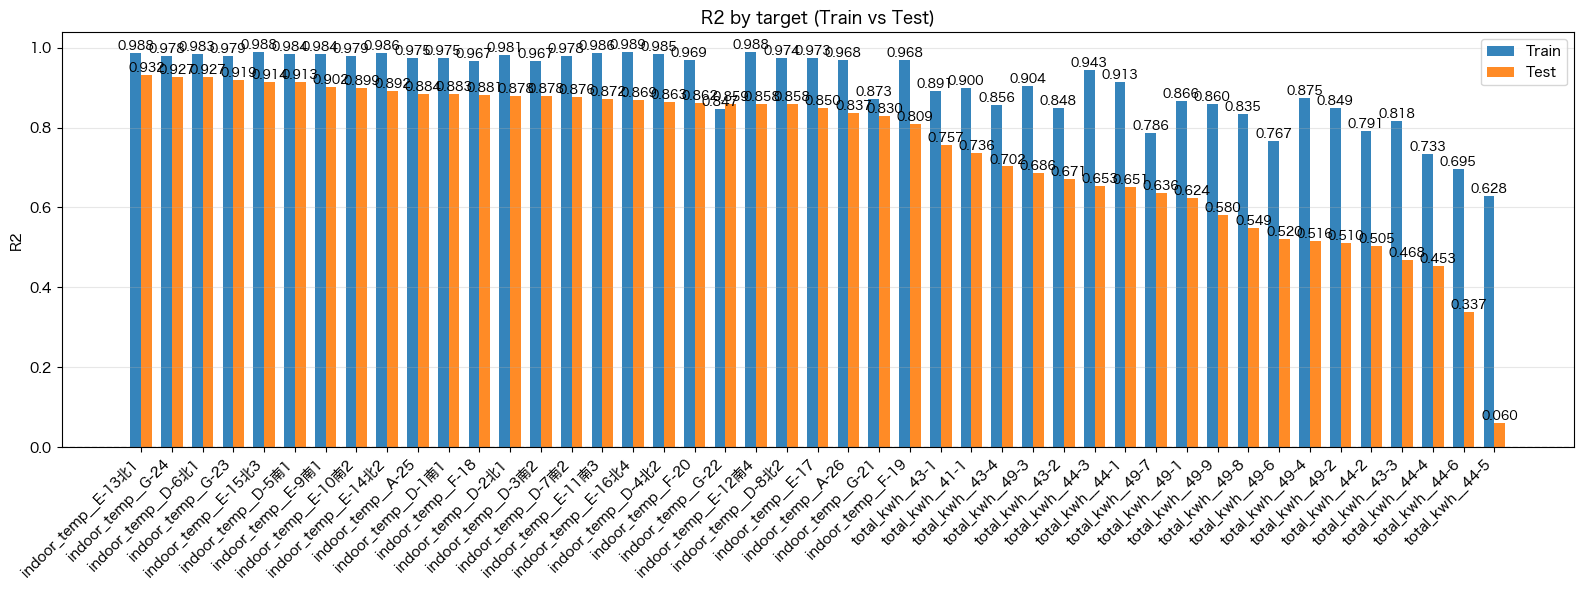

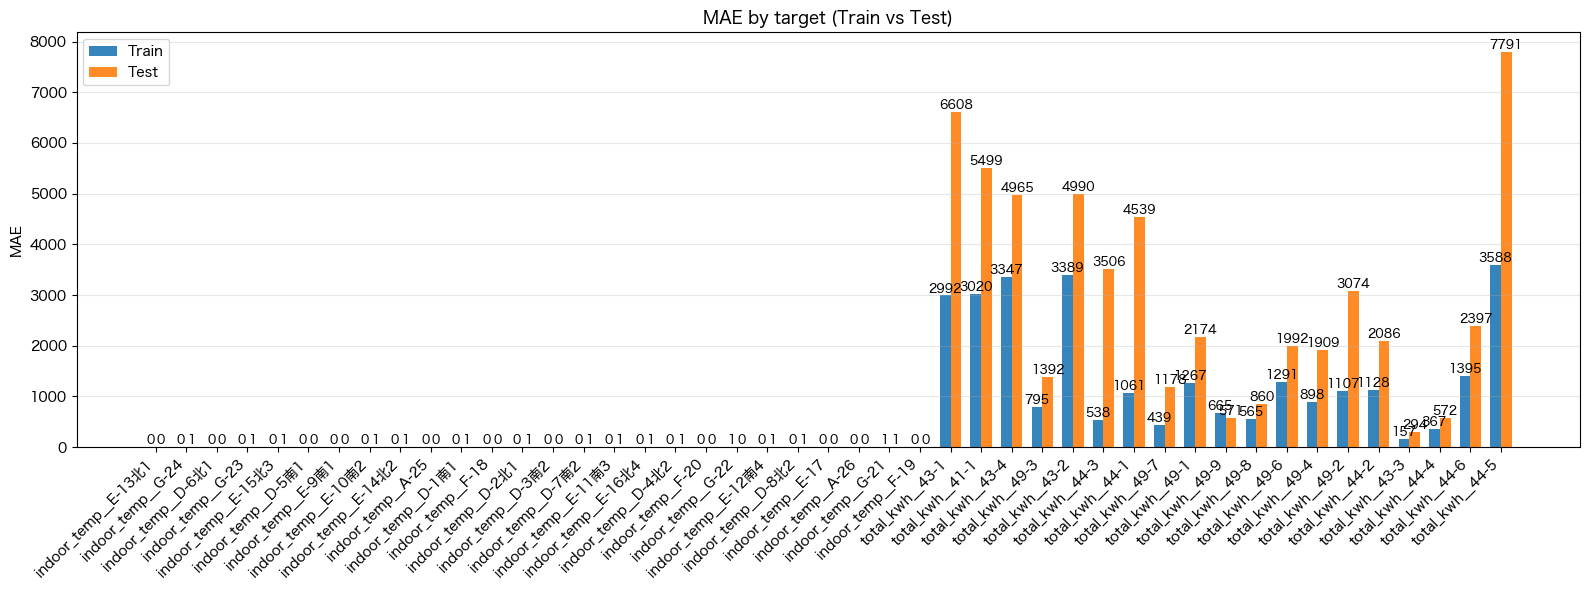

In [65]:
# 並べ棒で可視化（R2 で降順、上位30件だけ見たい例）
tbl_used = plot_residual_metrics(res, sort_by="R2", top_n=45, figsize=(16, 6))

In [54]:
# === 置き換え：Feature Importance 抽出まわり（これだけ差し替えればOK） ===
from typing import Any, Dict, List, Optional
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import re

_FIDX_RE = re.compile(r"^f(\d+)$")


def _booster_from_any(est: Any) -> Optional[xgb.Booster]:
    if isinstance(est, xgb.Booster):
        return est
    if hasattr(est, "get_booster"):
        try:
            b = est.get_booster()
            if isinstance(b, xgb.Booster):
                return b
        except Exception:
            pass
    for attr in ("booster_", "booster"):
        if hasattr(est, attr) and isinstance(getattr(est, attr), xgb.Booster):
            return getattr(est, attr)
    return None


def _importance_df_from_estimator(
    est: Any,
    feature_names: List[str],
    importance_type: str = "gain",
) -> pd.DataFrame:
    """
    どの形式でも必ず feature_names 順に並べた DF を返す。
    - get_score のキーが f0,f1,... の「番号」形式でも
    - 実際の「列名」形式でもOK
    - どちらも出なければ feature_importances_ をフォールバック
    """
    booster = _booster_from_any(est)

    if booster is not None:
        raw = booster.get_score(importance_type=importance_type) or {}
        if raw:
            keys = list(raw.keys())
            # 1) キーが 'f123' の番号形式
            if all(_FIDX_RE.match(k) for k in keys):
                scores = np.zeros(len(feature_names), dtype=float)
                for k, v in raw.items():
                    i = int(_FIDX_RE.match(k).group(1))
                    if 0 <= i < len(scores):
                        scores[i] = float(v)
                df = pd.DataFrame({"feature": feature_names, "importance": scores})
                df = df.sort_values("importance", ascending=False).reset_index(
                    drop=True
                )
                return df
            # 2) キーが実列名
            else:
                s = pd.Series({str(k): float(v) for k, v in raw.items()})
                s = s.reindex(feature_names, fill_value=0.0)
                df = s.sort_values(ascending=False).reset_index()
                df.columns = ["feature", "importance"]
                return df

    # 3) フォールバック：sklearn API
    if hasattr(est, "feature_importances_"):
        vals = np.asarray(est.feature_importances_, dtype=float)
        vals = vals[: len(feature_names)]
        df = pd.DataFrame({"feature": feature_names, "importance": vals})
        df = df.sort_values("importance", ascending=False).reset_index(drop=True)
        return df

    # 4) それでも出せない場合はゼロで返す（空防止）
    df = pd.DataFrame({"feature": feature_names, "importance": 0.0})
    return df


def _as_name_to_estimator_map(model: Any, y_cols: List[str]) -> Dict[str, Any]:
    if not hasattr(model, "estimators_"):
        name = y_cols[0] if len(y_cols) == 1 else "y0"
        return {name: model}
    ests = getattr(model, "estimators_")
    names = y_cols if len(ests) == len(y_cols) else [f"y{i}" for i in range(len(ests))]
    return dict(zip(names, ests))


def compute_importance_for_targets(
    res: Dict[str, Any],
    X_features: pd.DataFrame,
    targets: Optional[List[str]] = None,
    *,
    importance_type: str = "gain",
    top_n: Optional[int] = None,
) -> Dict[str, pd.DataFrame]:
    model = res["model"]
    y_cols: List[str] = list(res["Y_cols"])
    x_cols: List[str] = list(res.get("X_cols", list(X_features.columns)))

    name_to_est = _as_name_to_estimator_map(model, y_cols)
    tgt_list = targets or list(name_to_est.keys())

    out: Dict[str, pd.DataFrame] = {}
    for t in tgt_list:
        est = name_to_est[t]
        df = _importance_df_from_estimator(est, x_cols, importance_type=importance_type)
        if top_n is not None:
            df = df.head(top_n).copy()
        out[t] = df
    return out


def plot_feature_importance_for_targets_compat(
    res: Dict[str, Any],
    X_features: pd.DataFrame,
    targets: Optional[List[str]] = None,
    *,
    importance_type: str = "gain",
    top_n: int = 20,
    ncols: int = 2,
    figsize_per_panel=(6, 4),
):
    imps = compute_importance_for_targets(
        res, X_features, targets, importance_type=importance_type, top_n=top_n
    )
    names = list(imps.keys())
    n = len(names)
    ncols = max(1, ncols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(figsize_per_panel[0] * ncols, figsize_per_panel[1] * nrows),
        squeeze=False,
    )
    ax_list = axes.ravel()
    for i, t in enumerate(names):
        ax = ax_list[i]
        df = imps[t]
        ax.barh(df["feature"][::-1], df["importance"][::-1])
        ax.set_title(f"Feature Importance ({importance_type}) — {t}")
        ax.set_xlabel(importance_type)
        ax.set_ylabel("feature")
    for j in range(len(names), len(ax_list)):
        fig.delaxes(ax_list[j])
    fig.tight_layout()
    fig.show()

In [69]:
# y_cols = list(res["Y_cols"])  # 既存の学習結果から列名
# # 例: すべてのターゲットを可視化
# plot_feature_importance_for_targets_compat(
#     res,
#     X_features,
#     targets=y_cols,  # or ["targetA", "targetB"] で絞り込み
#     importance_type="weight",  # "weight", "cover", "total_gain", "total_cover" も可
#     top_n=10,
# )

- 元のスケールの戻すコード


In [16]:
import numpy as np
import pandas as pd
from typing import Sequence, Optional


def predict_full_period_with_residual_model(
    model,
    X_full: pd.DataFrame,
    *,
    model_target_names: Sequence[str],  # 学習時 Y.columns の並び（必須）
    wanted_target_cols: Optional[Sequence[str]] = None,  # 返したい列（省略で全列）
    bl_prefix: str = "bl__",
    add_back_baseline: bool = True,
    fill_missing_baseline: float = 0.0,
    coerce_numeric: bool = True,
) -> dict:
    """
    残差モデル（Y_res = Y - BL）で全期間を予測。
    - model_target_names: 学習時ターゲット列名の順序（predict の列順と一致させる）。
    - wanted_target_cols: 返却したい列（例: ["total_kwh__49-9"]）。None なら全列。
    戻り値: {"y_res_pred": DataFrame, "y_pred": DataFrame(任意)}
    """
    if not model_target_names:
        raise ValueError(
            "model_target_names（学習時のターゲット列名の並び）を渡してください。"
        )

    # X 整形
    Xf = X_full.copy()
    if coerce_numeric:
        Xf = Xf.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # 学習時特徴量順に合わせる
    if hasattr(model, "feature_names_in_"):
        X_used = Xf.reindex(columns=list(model.feature_names_in_), fill_value=0.0)
    else:
        X_used = Xf  # 列順が一致している前提

    # 予測（残差）
    y_res_np = model.predict(X_used)  # (n_samples, n_targets) 期待
    if y_res_np.ndim == 1:
        y_res_np = y_res_np.reshape(-1, 1)

    n_samples, n_outputs = y_res_np.shape
    if n_outputs != len(model_target_names):
        raise ValueError(
            f"モデル出力数({n_outputs})と model_target_names({len(model_target_names)}) が不一致です。"
        )

    # DataFrame 化（全ターゲット）
    all_cols = list(model_target_names)
    y_res_all = pd.DataFrame(y_res_np, index=Xf.index, columns=all_cols)

    # 必要列だけ選択
    if wanted_target_cols is None:
        y_res_pred = y_res_all
        used_targets = all_cols
    else:
        missing = [c for c in wanted_target_cols if c not in all_cols]
        if missing:
            raise KeyError(f"wanted_target_cols に未知列があります: {missing}")
        y_res_pred = y_res_all[wanted_target_cols]
        used_targets = list(wanted_target_cols)

    out = {"y_res_pred": y_res_pred}

    # 元スケールへ戻す（Y = Y_res + BL）
    if add_back_baseline:
        bl_df = pd.DataFrame(index=Xf.index, columns=used_targets, dtype=float)
        for col in used_targets:
            bl_col = bl_prefix + col
            if bl_col in Xf.columns:
                bl_df[col] = pd.to_numeric(Xf[bl_col], errors="coerce")
            else:
                bl_df[col] = float(fill_missing_baseline)
        bl_df = bl_df.fillna(fill_missing_baseline)
        out["y_pred"] = y_res_pred.add(bl_df, fill_value=0.0)

    return out

In [54]:
res.get("model")

<__main__.train_xgb_multioutput.<locals>.MultiOutputXGB_Compat at 0x30279e5d0>

In [117]:
model_target_names = list(Y_features.columns)  # ← 学習時Yの列順を保存しておく

# 予測（単一列を欲しい場合）
res_all = predict_full_period_with_residual_model(
    model=res.get("model"),
    X_full=X_features,
    model_target_names=model_target_names,
    wanted_target_cols=model_target_names,  # ← ココで1列だけ指定
    bl_prefix="bl__",
    add_back_baseline=True,
)

Y_res_pred = res_all["y_res_pred"]  # 残差予測（1列）
Y_pred = res_all["y_pred"]  # 元スケール（1列）

In [120]:
def _make_target_frame_from_base(
    base_df: pd.DataFrame,
    y_cols: list[str],
    *,
    indoor_prefix="Indoor Temp.__",
    out_indoor_prefix="indoor_temp__",
) -> pd.DataFrame:
    """base_dfから y_cols（total_kwh__*, indoor_temp__*）に対応する元系列を集めて返す。"""
    df = pd.DataFrame(index=base_df.index)
    for c in y_cols:
        if c.startswith("total_kwh__"):
            if c in base_df.columns:
                df[c] = base_df[c]
        elif c.startswith(out_indoor_prefix):
            orig = indoor_prefix + c[len(out_indoor_prefix) :]
            if orig in base_df.columns:
                df[c] = base_df[orig].values
    return df


def restore_raw_predictions(
    base_df: pd.DataFrame,
    res_pack: dict,  # fit_predict_eval_xgb_residual_only の戻り値
    *,
    split: str = "te",  # "tr" or "te"（どちらを復元するか）
    days_for_baseline: int = 7,
    baseline_fallback: float = 0.0,
    indoor_prefix: str = "Indoor Temp.__",
    out_indoor_prefix: str = "indoor_temp__",
    horizon_hours: int = 0,  # 先読み学習している場合はそのホライズン（例: 1）
    use_freq_shift: bool = True,  # 欠番があるなら True 推奨
) -> pd.DataFrame:
    """
    残差予測を Raw に復元して DataFrame を返す。
    baselineは base_df から再計算して、必要なら t+Δ にシフトする。
    """
    y_cols = res_pack["Y_cols"]
    idx = res_pack["idx_tr"] if split == "tr" else res_pack["idx_te"]
    y_res_hat = res_pack["Y_res_hat_tr"] if split == "tr" else res_pack["Y_res_hat_te"]

    # 1) 対象列の元系列を base_df から作る（列名は y_cols と揃える）
    Y_src = _make_target_frame_from_base(
        base_df,
        y_cols,
        indoor_prefix=indoor_prefix,
        out_indoor_prefix=out_indoor_prefix,
    )

    # 2) baseline 再計算（過去N日同時刻平均）
    Y_bl = compute_same_time_baseline(
        Y_src, y_cols, days=days_for_baseline, fallback=baseline_fallback
    )

    # 3) 先読み学習（t→t+Δ）をしているなら baseline を +Δ へずらす
    if horizon_hours != 0:
        if use_freq_shift:
            Y_bl = Y_bl.shift(freq=pd.Timedelta(hours=horizon_hours))
        else:
            Y_bl = Y_bl.shift(-horizon_hours)

    # 4) インデックスを合わせて復元
    Y_bl_idx = Y_bl.loc[idx].values
    Y_raw_hat = Y_bl_idx + y_res_hat

    return pd.DataFrame(Y_raw_hat, index=idx, columns=y_cols)

In [80]:
y_hat_raw_te = restore_raw_predictions(base_df, res, split="te", horizon_hours=0)

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Literal
from matplotlib.lines import Line2D


def plot_hour_by_month_multi(
    df: pd.DataFrame,
    *,
    date_col: str | None = "ds",  # DatetimeIndexなら None
    value_cols: Sequence[str] = (),
    agg: Literal["mean", "median"] = "mean",
    figsize=(20, 12),
    sharey: bool = True,
    suptitle: str | None = None,
    hour_tick_step: int = 2,
):
    if (
        date_col is not None
        and date_col not in df.columns
        and not isinstance(df.index, pd.DatetimeIndex)
    ):
        raise ValueError(
            f"date_col='{date_col}' が見つからず、indexもDatetimeIndexではありません。"
        )
    if not value_cols:
        raise ValueError("value_cols を1つ以上指定してください。")

    d = df.copy()

    # 日付分解
    if date_col is None and isinstance(d.index, pd.DatetimeIndex):
        dt = d.index
        year = pd.Series(dt.year, index=d.index)
        month = pd.Series(dt.month, index=d.index)
        hour = pd.Series(dt.hour, index=d.index)
    else:
        dt = pd.to_datetime(d[date_col], errors="coerce")
        if dt.isna().all():
            raise ValueError(
                f"date_col='{date_col}' をdatetimeへ変換できませんでした。"
            )
        year, month, hour = dt.dt.year, dt.dt.month, dt.dt.hour

    d["_year"], d["_month"], d["_hour"] = year, month, hour

    # 集計
    vals = [c for c in value_cols if c in d.columns]
    missing = [c for c in value_cols if c not in d.columns]
    if missing:
        print("[WARN] 存在しない列を無視します ->", missing)
    if not vals:
        raise ValueError("指定した value_cols が DataFrame に存在しません。")

    group_keys = ["_year", "_month", "_hour"]
    if agg == "mean":
        g = d.groupby(group_keys, dropna=True)[vals].mean().reset_index()
    else:
        g = d.groupby(group_keys, dropna=True)[vals].median().reset_index()

    # 図準備
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=figsize, sharey=sharey)
    axes = axes.flatten()

    # 列→色 固定
    base_colors = plt.rcParams.get("axes.prop_cycle", None)
    base_colors = (
        base_colors.by_key().get("color", None) if base_colors else None
    ) or [f"C{i}" for i in range(10)]
    col_to_color = {c: base_colors[i % len(base_colors)] for i, c in enumerate(vals)}

    # 年→マーカー 固定
    years_sorted = sorted(g["_year"].unique())
    marker_cycle = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*", "h", "H", "p"]
    year_to_marker = {
        y: marker_cycle[i % len(marker_cycle)] for i, y in enumerate(years_sorted)
    }

    # 凡例プロキシ
    year_legend_handles = [
        Line2D(
            [0],
            [0],
            marker=year_to_marker[y],
            linestyle="None",
            markerfacecolor="white",
            markeredgecolor="black",
            color="black",
            label=str(y),
        )
        for y in years_sorted
    ]
    col_legend_handles = [
        Line2D([0], [0], linestyle="-", color=col_to_color[c], label=c) for c in vals
    ]

    # 12面描画
    for ax_idx, month_num in enumerate(range(1, 13)):
        ax = axes[ax_idx]
        # （色サイクルは使わないが、互換用にNoneを設定してもOK）
        try:
            ax.set_prop_cycle(None)
        except Exception:
            pass

        data_m = g[g["_month"] == month_num]
        if data_m.empty:
            ax.set_title(f"Month {month_num} (no data)")
            ax.set_xticks(range(0, 24, hour_tick_step))
            ax.grid(True, alpha=0.3)
            if ax_idx % 4 == 0:
                ax.set_ylabel("Value")
            continue

        for y, ydf in data_m.groupby("_year"):
            for c in vals:
                color = col_to_color[c]
                ax.plot(
                    ydf["_hour"].to_numpy(),
                    ydf[c].to_numpy(),
                    color=color,  # 色=列で固定
                    marker=year_to_marker[y],  # 形=年で固定
                    markerfacecolor="white",
                    markeredgecolor=color,
                    linewidth=1.6,
                    label=None,
                )

        ax.set_title(f"Month {month_num}")
        ax.set_xlabel("Hour of day")
        ax.set_xticks(range(0, 24, hour_tick_step))
        ax.grid(True, alpha=0.3)
        if ax_idx % 4 == 0:
            ax.set_ylabel("Value")

    if suptitle:
        fig.suptitle(suptitle, y=0.98, fontsize=14)

    fig.legend(
        handles=col_legend_handles,
        labels=[h.get_label() for h in col_legend_handles],
        title="Columns (color)",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.03),
        ncol=min(len(col_legend_handles), 4),
        frameon=False,
    )
    fig.legend(
        handles=year_legend_handles,
        labels=[h.get_label() for h in year_legend_handles],
        title="Year (marker)",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.10),
        ncol=min(len(year_legend_handles), 8),
        frameon=False,
    )

    plt.tight_layout(rect=(0, 0.08, 1, 0.95))
    plt.show()

In [103]:
EDA_data = X_features.copy()

In [121]:
base_df_nodup = base_df[~base_df.index.duplicated(keep="last")]
Xf_nodup = X_features[~X_features.index.duplicated(keep="last")]

# 共通インデックスを取り出して base_df 側に適用（順序はソートしておく）
common_idx = base_df_nodup.index.intersection(Xf_nodup.index).sort_values()
base_df_only_common = base_df_nodup.reindex(common_idx)

In [122]:
EDA_data["datetime"] = base_df_only_common.index.to_list()
EDA_data["total_kwh__49-9"] = base_df_only_common["total_kwh__49-9"].to_list()
pred_cols = ["pred_" + c for c in Y_features.columns]
EDA_data[pred_cols] = Y_res_pred

In [123]:
DataManager.show_status(EDA_data)

+----------------------------------+-------------+----------------+------------+----------+
|             Variable             |     Type    | Missing Values | Duplicates | Outliers |
+----------------------------------+-------------+----------------+------------+----------+
|               hour               |  Numerical  |       0        |   10703    |    0     |
|              month               |  Numerical  |       0        |   10715    |    0     |
|             weekday              |  Numerical  |       0        |   10720    |    0     |
|            is_weekend            |  Numerical  |       0        |   10725    |    0     |
|      bl__indoor_temp__A-25       |  Numerical  |       0        |    6532    |    0     |
|      bl__indoor_temp__A-26       |  Numerical  |       0        |    6474    |    0     |
|     bl__indoor_temp__D-1南1      |  Numerical  |       0        |    7116    |   151    |
|     bl__indoor_temp__D-2北1      |  Numerical  |       0        |    6448    |  

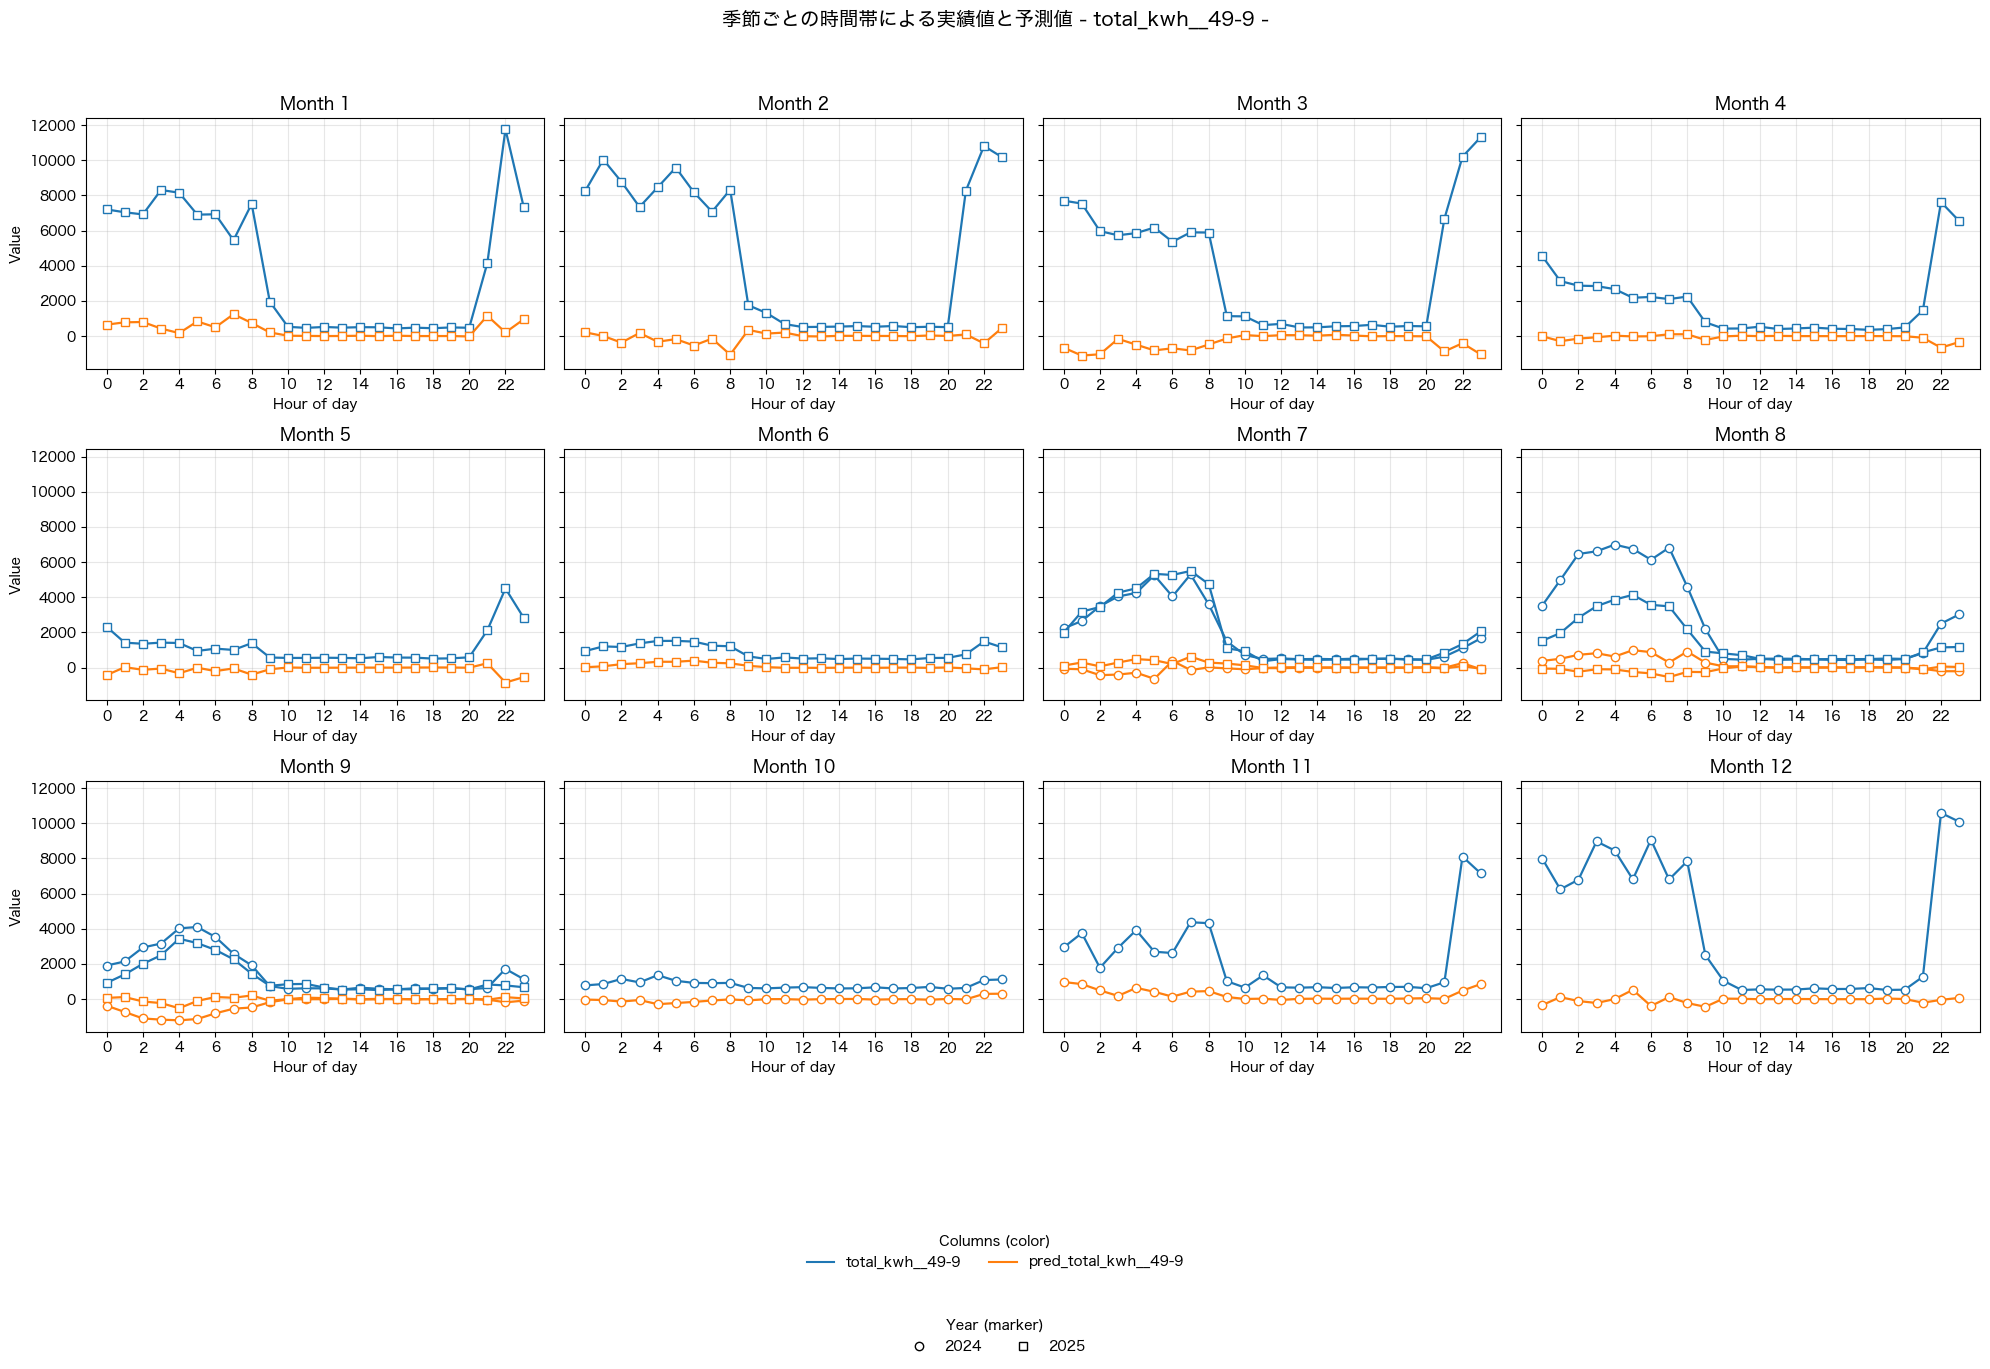

In [107]:
plot_hour_by_month_multi(
    EDA_data,  # もしくは自前の日時列
    date_col="datetime",
    value_cols=["total_kwh__49-9", "pred_total_kwh__49-9"],
    agg="mean",  # or "median"
    suptitle="季節ごとの時間帯による実績値と予測値 - total_kwh__49-9 -",
)

上記の結果から、予測結果に乖離が生じたのはベースラインが現実の傾向を捉えきれていないからだと分かる。
<br>そこで、乖離が激しい区間は、何が影響しているのかを解明する


In [199]:
def _make_is_weekday(dt_index_or_series) -> pd.Series:
    """Mon-Fri→1(平日), Sat/Sun→0(休日)"""
    if isinstance(dt_index_or_series, pd.DatetimeIndex):
        wd = pd.Series(dt_index_or_series.weekday, index=dt_index_or_series)
    else:
        wd = pd.to_datetime(dt_index_or_series, errors="coerce").dt.weekday
    return (wd < 5).astype(int)


def plot_hour_by_month_weektype_color(
    df: pd.DataFrame,
    *,
    date_col: Optional[str] = "ds",  # DatetimeIndexなら None
    value_col: str = "total_kwh__49-9",  # 可視化対象
    agg: Literal["mean", "median"] = "mean",
    figsize=(20, 12),
    sharey: bool = True,
    suptitle: Optional[str] = None,
    hour_tick_step: int = 2,
    weekday_flag_col: Optional[str] = None,  # 1=平日,0=休日 が入っていれば利用
):
    # --- 入力チェック ---
    if (
        date_col is not None
        and date_col not in df.columns
        and not isinstance(df.index, pd.DatetimeIndex)
    ):
        raise ValueError(
            f"date_col='{date_col}' が見つからず、indexもDatetimeIndexではありません。"
        )
    if value_col not in df.columns:
        raise ValueError(f"value_col='{value_col}' が DataFrame にありません。")

    d = df.copy()

    # --- 日付分解 ---
    if date_col is None and isinstance(d.index, pd.DatetimeIndex):
        dt = d.index
        d["_year"] = dt.year
        d["_month"] = dt.month
        d["_hour"] = dt.hour
        is_wd_src = dt
    else:
        dt = pd.to_datetime(d[date_col], errors="coerce")
        d["_year"] = dt.dt.year
        d["_month"] = dt.dt.month
        d["_hour"] = dt.dt.hour
        is_wd_src = dt

    # --- 平日/休日フラグ ---
    if weekday_flag_col and weekday_flag_col in d.columns:
        d["_is_weekday"] = d[weekday_flag_col].astype(int)  # 1=平日,0=休日想定
    else:
        d["_is_weekday"] = _make_is_weekday(is_wd_src)

    # --- 集計: year x month x hour x is_weekday ---
    group_keys = ["_year", "_month", "_hour", "_is_weekday"]
    if agg == "mean":
        g = d.groupby(group_keys, dropna=True)[value_col].mean().reset_index()
    else:
        g = d.groupby(group_keys, dropna=True)[value_col].median().reset_index()

    # --- 図準備 ---
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=figsize, sharey=sharey)
    axes = axes.flatten()

    # 色=平日/休日を固定
    # 平日=ブルー, 休日=オレンジ（任意で変更可）
    daytype_to_color = {1: "#1f77b4", 0: "#ff7f0e"}
    daytype_label = {1: "Weekday", 0: "Holiday"}

    # マーカー=年を固定
    years_sorted = sorted(g["_year"].unique())
    marker_cycle = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*", "h", "H", "p"]
    year_to_marker = {
        y: marker_cycle[i % len(marker_cycle)] for i, y in enumerate(years_sorted)
    }

    # 凡例プロキシ
    color_handles = [
        Line2D(
            [0], [0], color=daytype_to_color[k], linestyle="-", label=daytype_label[k]
        )
        for k in [1, 0]
    ]
    year_handles = [
        Line2D(
            [0],
            [0],
            marker=year_to_marker[y],
            linestyle="None",
            markerfacecolor="white",
            markeredgecolor="black",
            color="black",
            label=str(y),
        )
        for y in years_sorted
    ]

    # --- 12面描画 ---
    for ax_idx, month_num in enumerate(range(1, 13)):
        ax = axes[ax_idx]
        mdf = g[g["_month"] == month_num]
        if mdf.empty:
            ax.set_title(f"Month {month_num} (no data)")
            ax.set_xticks(range(0, 24, hour_tick_step))
            ax.grid(True, alpha=0.3)
            if ax_idx % 4 == 0:
                ax.set_ylabel(value_col)
            continue

        for (y, is_wd), sdf in mdf.groupby(["_year", "_is_weekday"]):
            ax.plot(
                sdf["_hour"].to_numpy(),
                sdf[value_col].to_numpy(),
                color=daytype_to_color[int(is_wd)],  # ← 色=平日/休日
                marker=year_to_marker[y],  # ← マーカー=年
                markerfacecolor="white",
                markeredgecolor=daytype_to_color[int(is_wd)],
                linewidth=1.6,
                label=None,
            )

        ax.set_title(f"Month {month_num}")
        ax.set_xlabel("Hour of day")
        ax.set_xticks(range(0, 24, hour_tick_step))
        ax.grid(True, alpha=0.3)
        if ax_idx % 4 == 0:
            ax.set_ylabel(value_col)

    if suptitle:
        fig.suptitle(suptitle, y=0.98, fontsize=14)

    # 凡例（色=平日/休日、マーカー=年）
    fig.legend(
        handles=color_handles,
        labels=[h.get_label() for h in color_handles],
        title="Day type (color)",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.03),
        ncol=2,
        frameon=False,
    )
    fig.legend(
        handles=year_handles,
        labels=[h.get_label() for h in year_handles],
        title="Year (marker)",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.10),
        ncol=min(len(year_handles), 8),
        frameon=False,
    )

    plt.tight_layout(rect=(0, 0.08, 1, 0.95))
    plt.show()

In [203]:
# plot_hour_by_month_weektype_color(
#     df=X_features,
#     date_col="datetime",
#     value_col="total_kwh__49-9",
#     agg="mean",  # または "median"
#     suptitle="total_kwh__49-9: color=Weekday/Holiday, marker=Year",
#     # weekday_flag_col="is_weekday",  # 既にフラグ列がある場合は指定（1=平日,0=休日）
# )

In [124]:
target = EDA_data[EDA_data["datetime"] == datetime(2025, 9, 10, 7)]
input_test = X_features[X_features.index == datetime(2025, 9, 10, 7)]

In [127]:
input_test["bl__total_kwh__49-9"]

Datetime_hour
2025-09-10 07:00:00    2270.714286
Name: bl__total_kwh__49-9, dtype: float64

In [126]:
target["pred_total_kwh__49-9"]

Datetime_hour
2025-09-10 07:00:00    1011.343994
Name: pred_total_kwh__49-9, dtype: float32